# Time Series Forecasting with XGBoost

#### Some previous information:

- The study of this dataset aims to find a way to predict the popularity of the music artist in the future based on sales, charts and rankings provided for Billboard curated lists.

- This dataset contains 233038 samples ready to feed the predictive model.

- There are three different scores categories 'Rank', 'Peak Position' and 'Weeks in Charts'. They are at the same time subdivided into different Charts from the Billboard Music Website. Those charts are: 'Hot100', 'Digital', 'Radio' and 'Streaming'. 

- Finally there is a Popularity Index scaled, manipulated and build based on a careful personal insight and domain knowledge and then formulated carefully with all of those features on the dataset. This will be the target of the model.

- I used XGBoost which is probably one of the best machine learning models for time analysis problems like this.

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import sys
project_path = '../_PAN_Project'
data_path = os.path.join(project_path, 'src', 'functions')
sys.path.append(data_path)

from PAN_functions_dt import create_artist_popularity_df

import xgboost as xgb 
from sklearn.metrics import root_mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
# The PAN_index_final dataset
pan_df = pd.read_csv('../PAN_index_final.csv', parse_dates=['Date'])

In [4]:
print('This dataset contains', (pan_df.shape[0] * pan_df.shape[1]) - pan_df.shape[0], 'samples')

This dataset contains 250964 samples


In [5]:
pan_df

Date                                Artist  Hot100 Rank  \
0     2020-01-01                          Mariah Carey            1   
1     2020-01-01                            Brenda Lee            2   
2     2020-01-01                           Bobby Helms            3   
3     2020-01-01                             Burl Ives            4   
4     2020-01-01                           Post Malone            5   
...          ...                                   ...          ...   
17921 2024-01-24                Noah Kahan With Hozier           95   
17922 2024-01-24  Thomas Rhett Featuring Morgan Wallen           96   
17923 2024-01-24                          Travis Scott           97   
17924 2024-01-24                         Dylan Gossett           99   
17925 2024-01-24                              Rod Wave          100   

       Digital Rank  Radio Rank  Streaming Rank  Hot100 Peak Position  \
0                 5          26               1                     1   
1                30          40               2                     2   
2                 0          41               3                     3   
3                 0          44               4                     4   
4                 6           1              38                     1   
...             ...         ...             ...                   ...   
17921             0           0               0                    37   
17922             0           0               0                    55   
17923             0           0               0                    19   
17924             0           0               0                    89   
17925             0           0               0                    30   

       Digital Peak Position  Radio Peak Position  Streaming Peak Position  \
0                          1                   12                        1   
1                         22                   28                        2   
2                          0                   30                        2   
3                          0                   32                        4   
4                          1                    1                        2   
...                      ...                  ...                      ...   
17921                      0                    0                        0   
17922                      0                    0                        0   
17923                      0                    0                        0   
17924                      0                    0                        0   
17925                      0                    0                        0   

       Hot100 Weeks in Charts  Digital Weeks in Charts  Radio Weeks in Charts  \
0                          37                       80                     36   
1                          32                       26                     19   
2                          30                        0                     15   
3                          15                        0                     13   
4                          17                       17                     16   
...                       ...                      ...                    ...   
17921                       7                        0                      0   
17922                       3                        0                      0   
17923                       7                        0                      0   
17924                       2                        0                      0   
17925                      17                        0                      0   

       Streaming Weeks in Charts  Popularity Index Scaled  
0                             32                90.227901  
1                             22                79.894832  
2                             16                77.857888  
3                             14                74.822416  
4                             17                78.795331  
...         

## 1. Looking like you're missing values/rows? README!!!!

This dataframe is the final PAN popularity index dataframe ready to be used for any predictive models. The Test feature is 'Popularity Index Scaled'.

You will see that some artist does not have information on certain dates. That is expected. Some of them didn't have any songs and therefore there is no data available.

I found a solution that could be implemented for each artist. I could have done differently, like implementing this same solution for the entire dataframe (all artist at once) but it has no sense at all and indeed beyond what is useful right now.
I import a function that creates dummy rows based on calculations from the previous 8 months the artist was on charts and then filling up the missing dates.

Why it is so important? 
because I need a nice historical data analysis without strange drop outs. We all can understand that popularity of an artist doesn't collapse just simply because there is no songs in charts at that moment.

In [6]:
# Sorting the best popularity index for each artist
result_df = pan_df.groupby('Artist')['Popularity Index Scaled'].max().reset_index()
result_df = result_df.sort_values(by='Popularity Index Scaled', ascending=False)
result_df.head()


Artist  Popularity Index Scaled
787    Mariah Carey               100.000000
1204     The Weeknd                98.900499
331        Dua Lipa                94.928830
423   Glass Animals                94.502493
147      Brenda Lee                92.359587

In [7]:
artist_to_check = ['The Weeknd','Billie Eilish','Miley Cyrus','Dua Lipa','Taylor Swift','Adele','Ariana Grande']
artist_popularity_versus = result_df.loc[result_df['Artist'].isin(artist_to_check)]
artist_popularity_versus


Artist  Popularity Index Scaled
1204     The Weeknd                98.900499
331        Dua Lipa                94.928830
1169   Taylor Swift                87.995240
128   Billie Eilish                85.224048
853     Miley Cyrus                83.821623
37            Adele                81.869447
61    Ariana Grande                78.974841

## 2. Dua Lipa Vs Taylor Swift

In [8]:
artist_name1 = 'Taylor Swift'
artist_name2 = 'Dua Lipa'
columns_to_calculate = ['Hot100 Rank', 'Digital Rank', 'Radio Rank','Streaming Rank', 'Hot100 Peak Position', 'Digital Peak Position',
       'Radio Peak Position', 'Streaming Peak Position','Hot100 Weeks in Charts', 'Digital Weeks in Charts',
       'Radio Weeks in Charts', 'Streaming Weeks in Charts','Popularity Index Scaled']  # Add other columns as needed


In [9]:
# Creating a dataframe only for an artist
taylor_swift_df = create_artist_popularity_df(artist_name1, pan_df, target_columns=columns_to_calculate)
dua_lipa_df = create_artist_popularity_df(artist_name2, pan_df, target_columns=columns_to_calculate)

In [10]:
taylor_swift_plot_df = taylor_swift_df[['Date','Popularity Index Scaled']]
dua_lipa_plot_df = dua_lipa_df[['Date','Popularity Index Scaled']]

<Axes: xlabel='Date'>

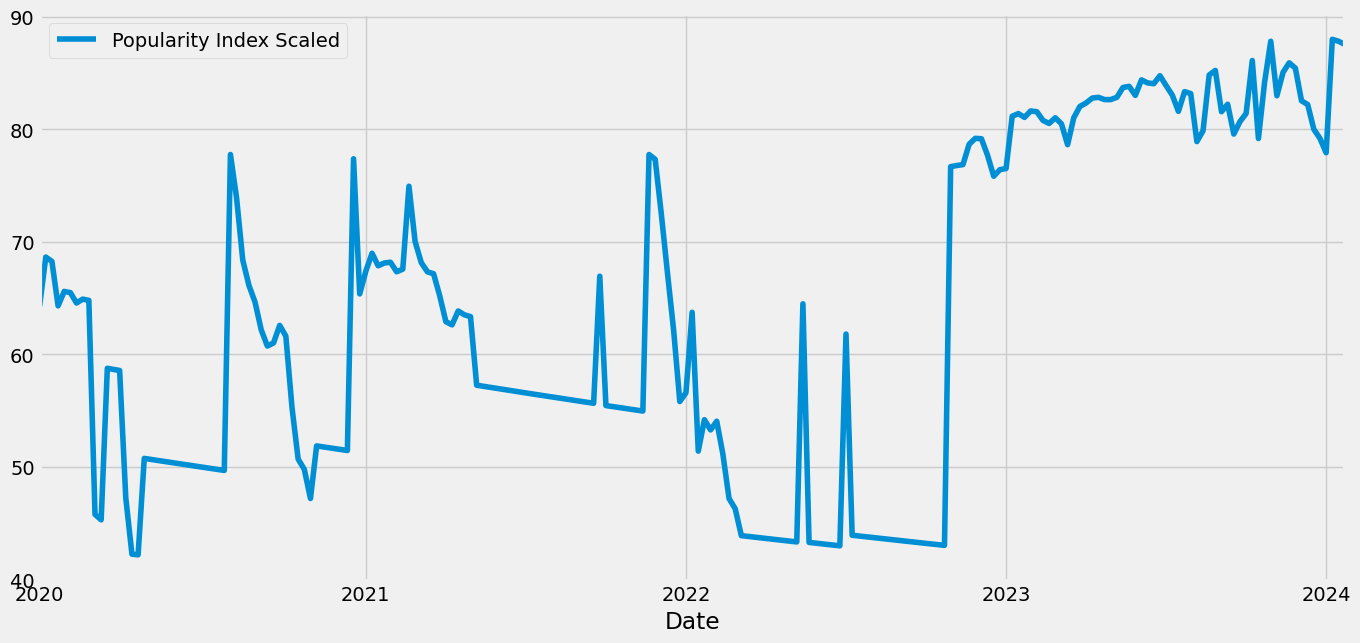

In [11]:
taylor_swift_plot_df.columns=["Date","Popularity Index Scaled"]
taylor_swift_plot_df.set_index('Date',inplace=True)

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7
taylor_swift_plot_df.plot()

<Axes: xlabel='Date'>

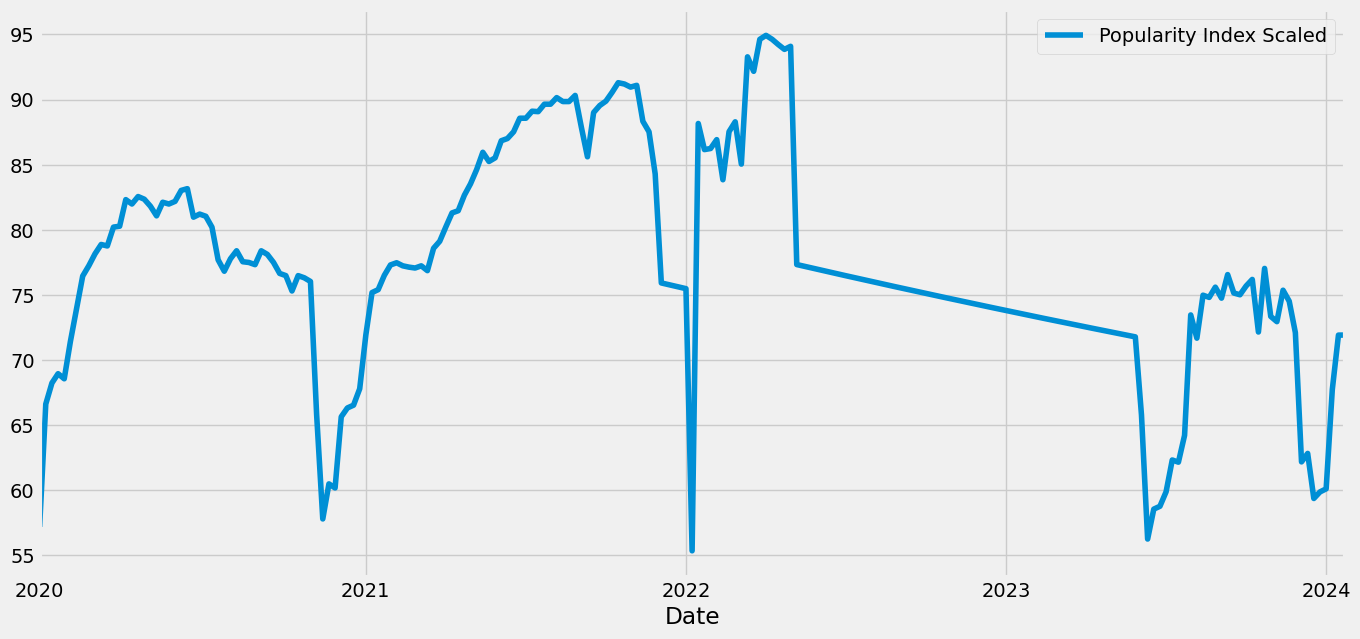

In [12]:
dua_lipa_plot_df.columns=["Date","Popularity Index Scaled"]
dua_lipa_plot_df.set_index('Date',inplace=True)

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7
dua_lipa_plot_df.plot()

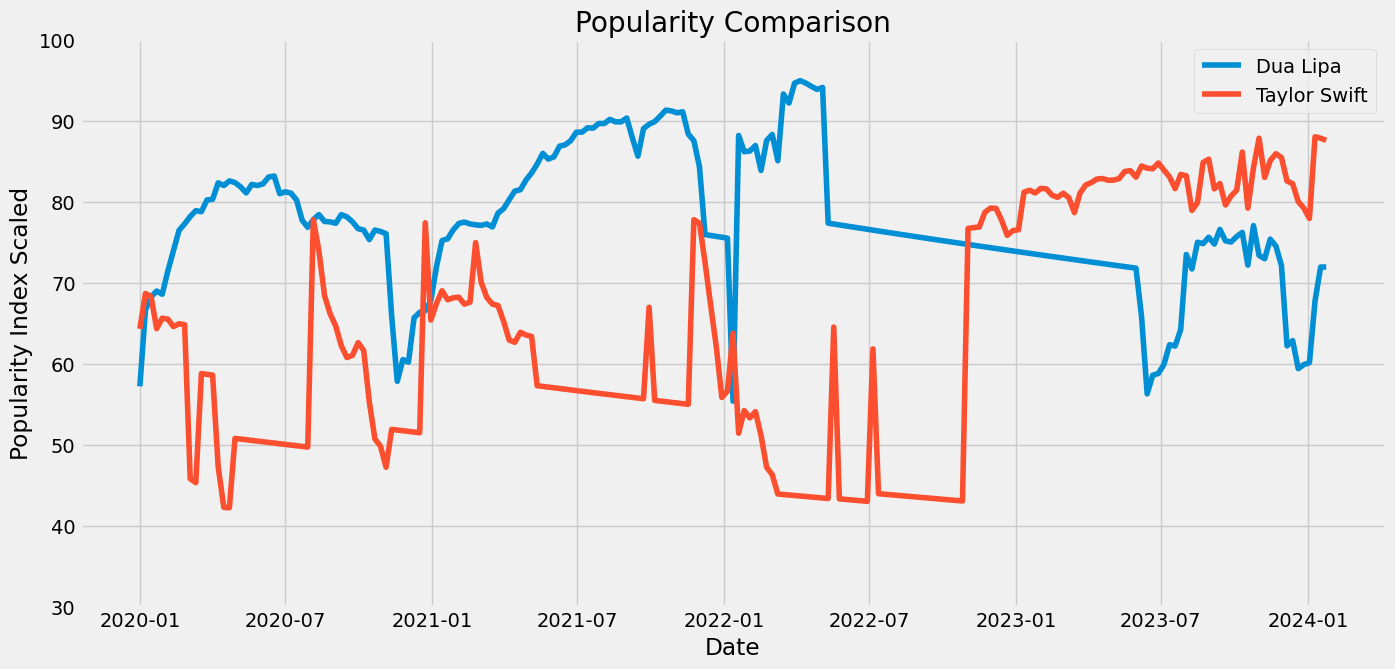

In [13]:
# Set the figure size
rcParams['figure.figsize'] = 15, 7

# Plot for Dua Lipa
plt.plot(dua_lipa_plot_df.index, dua_lipa_plot_df['Popularity Index Scaled'], label='Dua Lipa')

# Plot for Taylor Swift
plt.plot(taylor_swift_plot_df.index, taylor_swift_plot_df['Popularity Index Scaled'], label='Taylor Swift')

# Set y-axis limits
plt.ylim(30, 100)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Popularity Index Scaled')
plt.title('Popularity Comparison')
plt.legend()

# Show the combined plot
plt.show()



In [14]:
dua_lipa_plot_df

Popularity Index Scaled
Date                               
2020-01-01                57.197449
2020-01-08                66.622280
2020-01-15                68.237874
2020-01-22                68.955916
2020-01-29                68.563237
...                             ...
2023-12-27                59.879420
2024-01-03                60.115027
2024-01-10                67.735138
2024-01-17                71.917838
2024-01-24                71.921043

[213 rows x 1 columns]

### 2.1. Dua Lipa Predictive Modelling with XGBoost

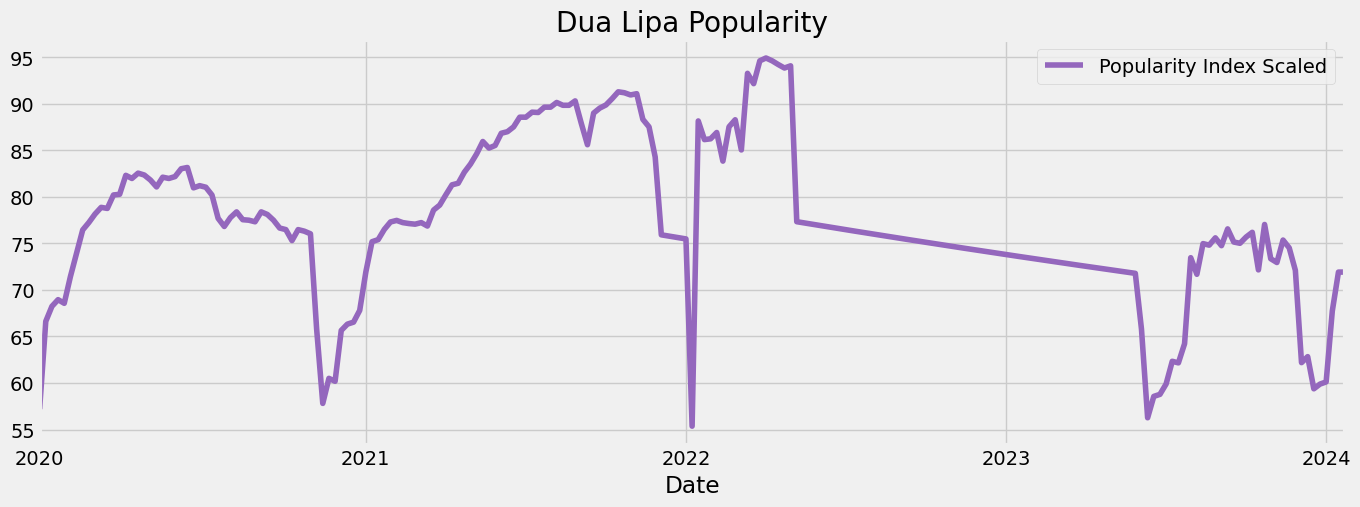

In [15]:
dua_lipa_plot_df.plot(style='-',
        figsize=(15, 5), 
        color=color_pal[4], 
        title='Dua Lipa Popularity')
plt.show()

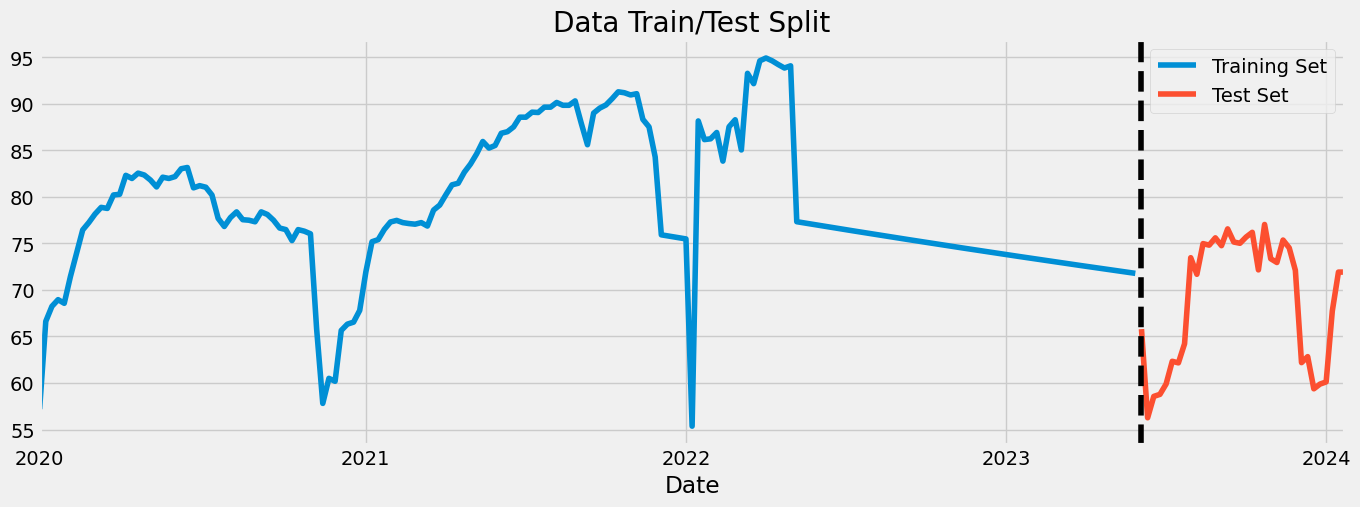

In [16]:
train = dua_lipa_plot_df.loc[dua_lipa_plot_df.index < '2023-06-01']
test = dua_lipa_plot_df.loc[dua_lipa_plot_df.index >= '2023-06-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label= 'Test Set')
ax.axvline('2023-06-01', color='black', ls='--')
ax.legend(['Training Set','Test Set'])
plt.show()

In [17]:
def create_features(df):
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

df = create_features(dua_lipa_plot_df)

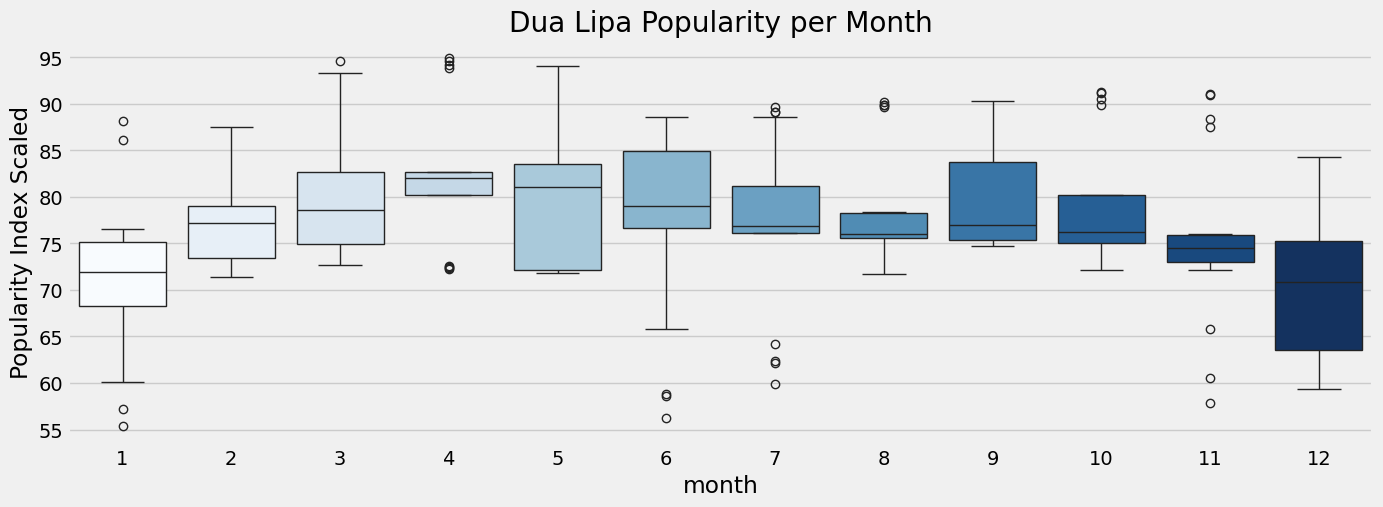

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x='month', y='Popularity Index Scaled', hue='month' ,palette='Blues', legend=False)
ax.set_title('Dua Lipa Popularity per Month')
plt.show()

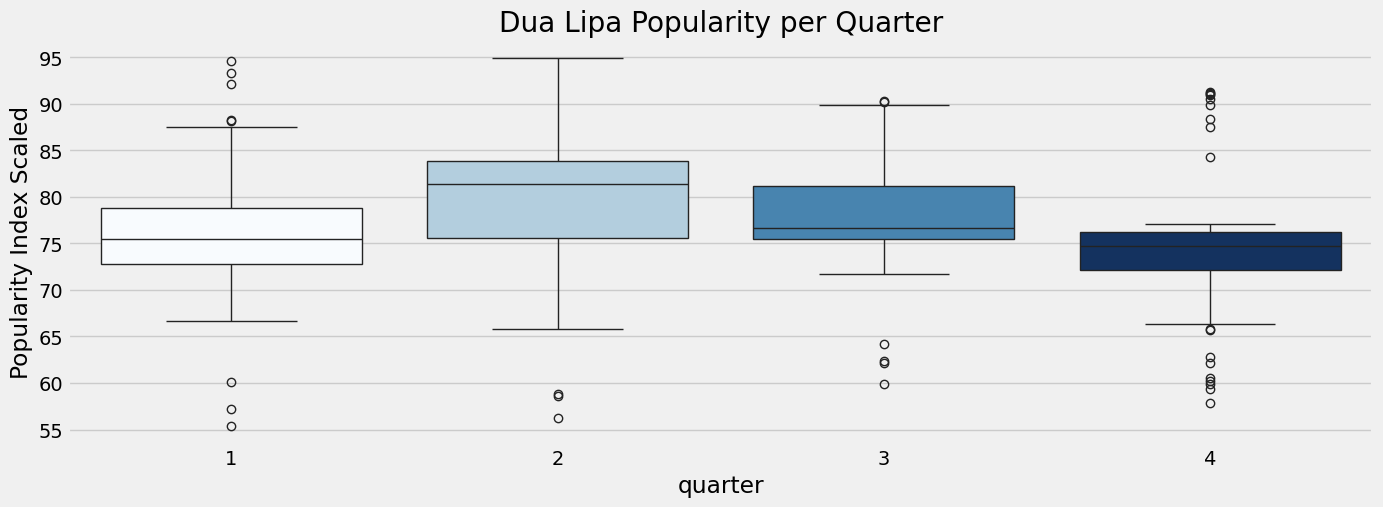

In [19]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x='quarter', y='Popularity Index Scaled', hue='quarter' ,palette='Blues', legend=False)
ax.set_title('Dua Lipa Popularity per Quarter')
plt.show()

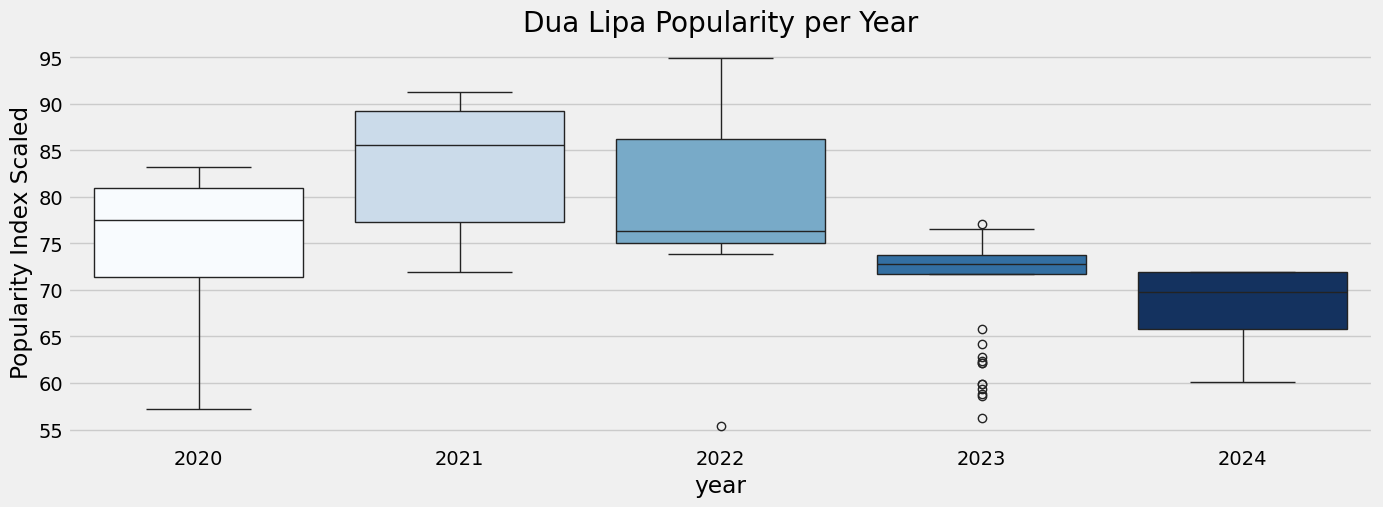

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x='year', y='Popularity Index Scaled', hue='year' ,palette='Blues', legend=False)
ax.set_title('Dua Lipa Popularity per Year')
plt.show()

#### Creating the Model

You can specify hyperparameter values to the class constructor to configure the model.

Perhaps the most commonly configured hyperparameters are the following:

- ***n_estimators***: The number of trees in the ensemble, often increased until no further improvements are seen.
- ***max_depth***: The maximum depth of each tree, often values are between 1 and 10.
- ***eta***: The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.
- ***subsample***: The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.
- ***colsample_bytree***: Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.

In [21]:
dua_lipa_df = dua_lipa_df.set_index('Date').copy()

In [22]:
train = dua_lipa_df.loc[dua_lipa_df.index < '2023-06-01']
test = dua_lipa_df.loc[dua_lipa_df.index >= '2023-06-01']

In [23]:
FEATURES = ['Hot100 Rank', 'Digital Rank', 'Radio Rank', 'Streaming Rank',
       'Hot100 Peak Position', 'Digital Peak Position', 'Radio Peak Position',
       'Streaming Peak Position', 'Hot100 Weeks in Charts',
       'Digital Weeks in Charts', 'Radio Weeks in Charts',
       'Streaming Weeks in Charts']
TARGET = ['Popularity Index Scaled']

In [24]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [25]:
model = xgb.XGBRegressor(
    n_estimators=1000, 
    early_stopping_rounds=50, 
    learning_rate=0.01
    )

model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=True)

[0]	validation_0-rmse:7.52841	validation_1-rmse:11.82749
[1]	validation_0-rmse:7.46081	validation_1-rmse:11.74804
[2]	validation_0-rmse:7.39391	validation_1-rmse:11.66976
[3]	validation_0-rmse:7.32765	validation_1-rmse:11.59224
[4]	validation_0-rmse:7.26203	validation_1-rmse:11.49710
[5]	validation_0-rmse:7.19702	validation_1-rmse:11.40263
[6]	validation_0-rmse:7.13265	validation_1-rmse:11.30950
[7]	validation_0-rmse:7.06881	validation_1-rmse:11.21625
[8]	validation_0-rmse:7.00562	validation_1-rmse:11.12488
[9]	validation_0-rmse:6.94301	validation_1-rmse:11.03393
[10]	validation_0-rmse:6.88097	validation_1-rmse:10.94372
[11]	validation_0-rmse:6.81957	validation_1-rmse:10.85544
[12]	validation_0-rmse:6.75870	validation_1-rmse:10.76702
[13]	validation_0-rmse:6.69845	validation_1-rmse:10.67983
[14]	validation_0-rmse:6.63875	validation_1-rmse:10.59428
[15]	validation_0-rmse:6.57961	validation_1-rmse:10.50897
[16]	validation_0-rmse:6.52101	validation_1-rmse:10.42426
[17]	validation_0-rmse:6

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [26]:
model.feature_importances_

array([0.0012862 , 0.00167274, 0.00230874, 0.00049748, 0.14016736,
       0.34585667, 0.00172822, 0.38183373, 0.00748509, 0.00556139,
       0.10732594, 0.00427649], dtype=float32)

In [27]:
fi = pd.DataFrame(
        data = model.feature_importances_,
        index = model.feature_names_in_,
        columns=['Dua Lipa score']
        )
fi

Dua Lipa score
Hot100 Rank                      0.001286
Digital Rank                     0.001673
Radio Rank                       0.002309
Streaming Rank                   0.000497
Hot100 Peak Position             0.140167
Digital Peak Position            0.345857
Radio Peak Position              0.001728
Streaming Peak Position          0.381834
Hot100 Weeks in Charts           0.007485
Digital Weeks in Charts          0.005561
Radio Weeks in Charts            0.107326
Streaming Weeks in Charts        0.004276

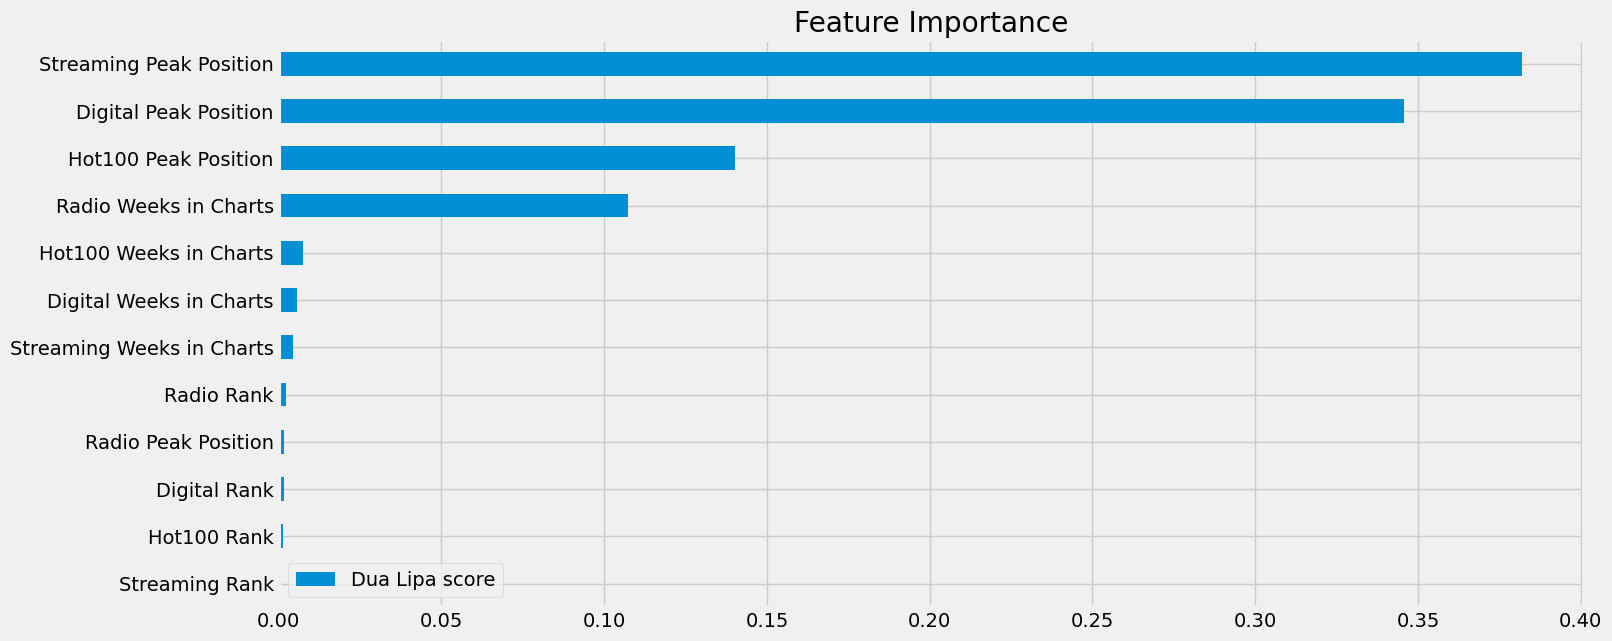

In [28]:
fi.sort_values(by='Dua Lipa score').plot(kind='barh', title='Feature Importance')
plt.show()

#### Predicting

In [29]:
model.predict(X_test)

array([74.05864 , 57.2254  , 57.2254  , 57.2254  , 57.2254  , 57.814186,
       57.813637, 60.307697, 69.49251 , 71.238014, 79.555824, 78.98984 ,
       79.69001 , 79.384056, 80.144775, 79.81356 , 79.88174 , 79.851524,
       79.81515 , 79.93319 , 77.81797 , 76.25947 , 77.727615, 78.125824,
       78.125824, 77.11479 , 62.13645 , 62.13658 , 62.113377, 62.113377,
       62.113377, 62.260796, 79.88464 , 76.80515 ], dtype=float32)

In [30]:
test['Prediction'] = model.predict(X_test)

/var/folders/9f/0437b_tn3hd136wm5vpp7y7h0000gn/T/ipykernel_15918/763973304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = model.predict(X_test)


- Now I have a prediction in the dataframe

In [31]:
df = df.merge(test[['Prediction']], how='left', left_index=True, right_index=True)
df

Popularity Index Scaled  quarter  month  year  Prediction
Date                                                                 
2020-01-01                57.197449        1      1  2020         NaN
2020-01-08                66.622280        1      1  2020         NaN
2020-01-15                68.237874        1      1  2020         NaN
2020-01-22                68.955916        1      1  2020         NaN
2020-01-29                68.563237        1      1  2020         NaN
...                             ...      ...    ...   ...         ...
2023-12-27                59.879420        4     12  2023   62.113377
2024-01-03                60.115027        1      1  2024   62.113377
2024-01-10                67.735138        1      1  2024   62.260796
2024-01-17                71.917838        1      1  2024   79.884644
2024-01-24                71.921043        1      1  2024   76.805153

[213 rows x 5 columns]

<Axes: xlabel='Date'>

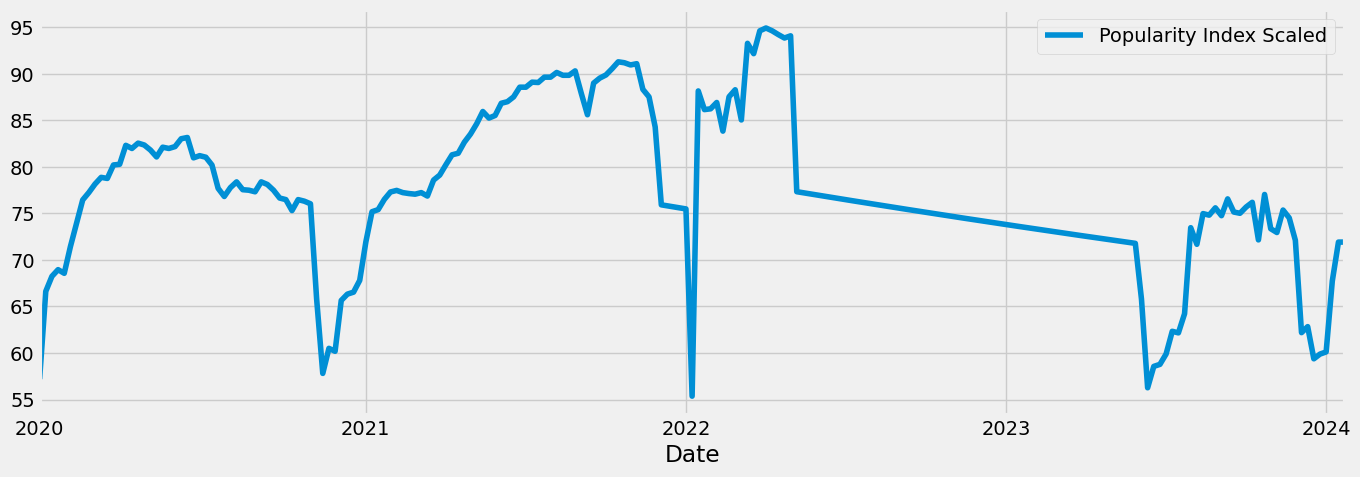

In [32]:
ax = df[['Popularity Index Scaled']].plot(figsize=(15, 5))
ax

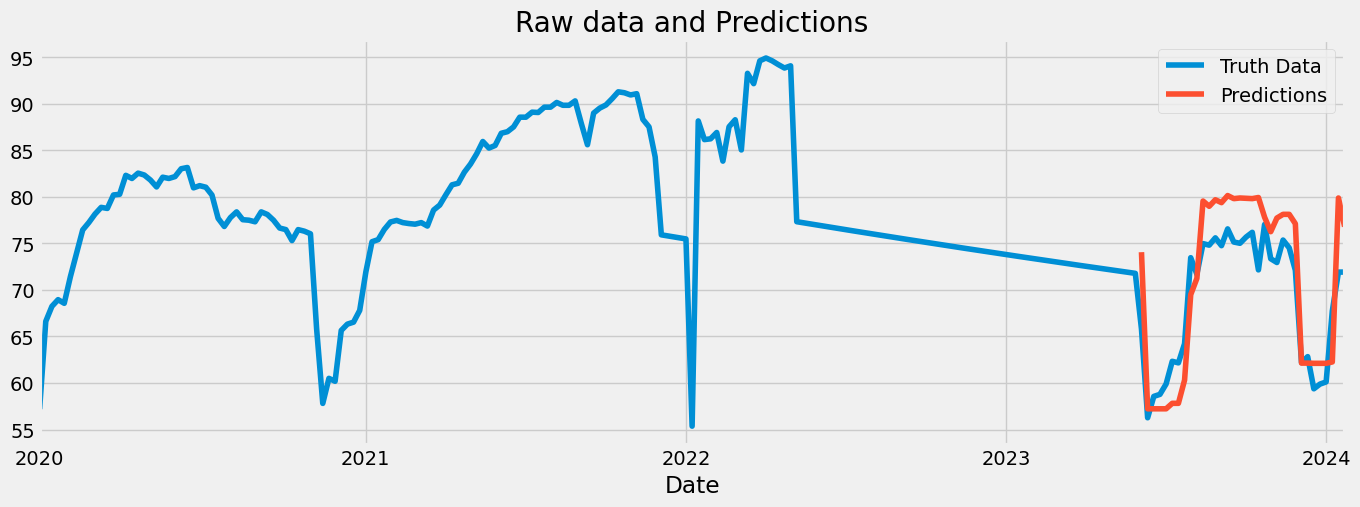

In [33]:
ax = df[['Popularity Index Scaled']].plot(figsize=(15, 5))
df['Prediction'].plot(ax=ax, style='-')
ax.set_title('Raw data and Predictions')
plt.legend(['Truth Data','Predictions'])
plt.show()

#### Score

In [34]:
score = root_mean_squared_error(test['Popularity Index Scaled'],test['Prediction'])
print(f'RMSE Score on test set : {score:0.2f}')

RMSE Score on test set : 4.16


---

### 2.2. Taylor Swift Predictive Modelling with XGBoost

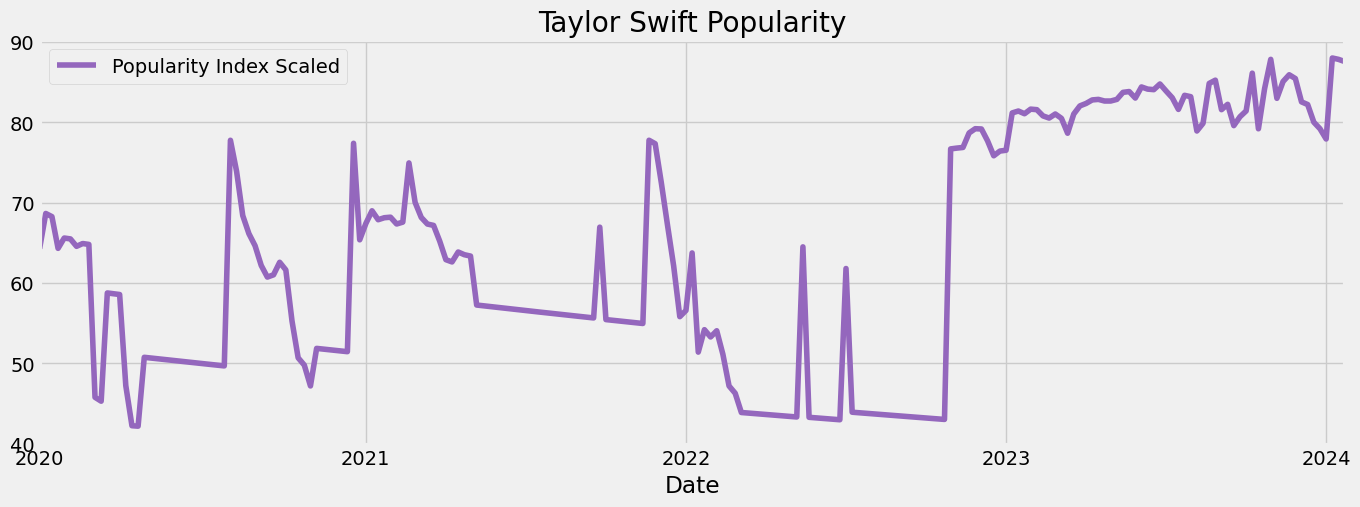

In [35]:
taylor_swift_plot_df.plot(style='-',
        figsize=(15, 5), 
        color=color_pal[4], 
        title='Taylor Swift Popularity')
plt.show()

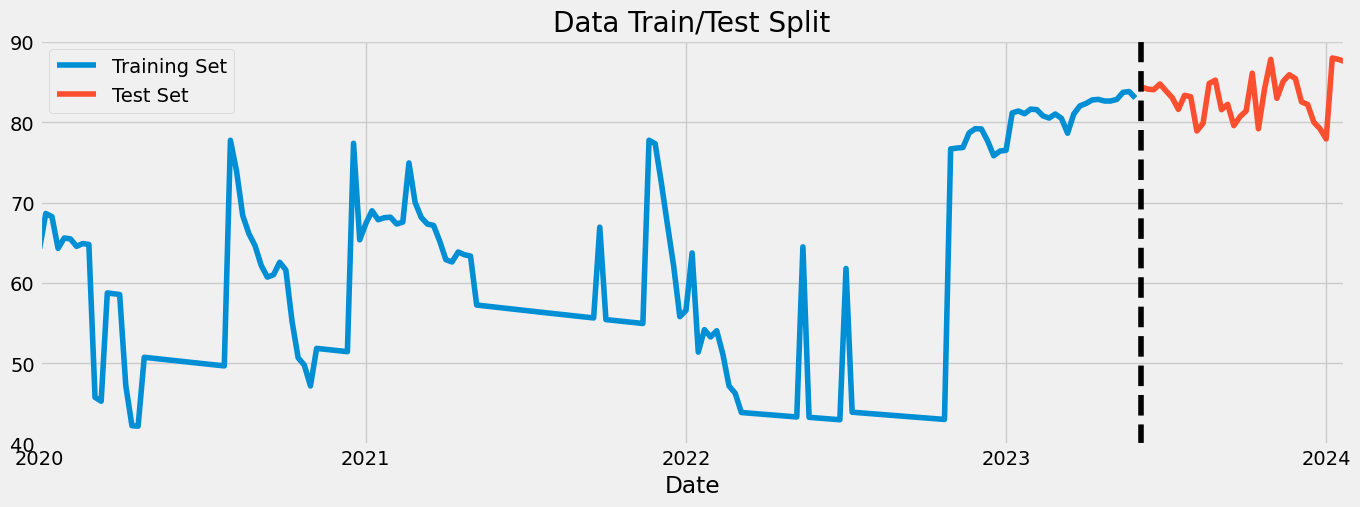

In [36]:
train = taylor_swift_plot_df.loc[taylor_swift_plot_df.index < '2023-06-01']
test = taylor_swift_plot_df.loc[taylor_swift_plot_df.index >= '2023-06-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label= 'Test Set')
ax.axvline('2023-06-01', color='black', ls='--')
ax.legend(['Training Set','Test Set'])
plt.show()

In [37]:
def create_features(df):
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

df2 = create_features(taylor_swift_plot_df)

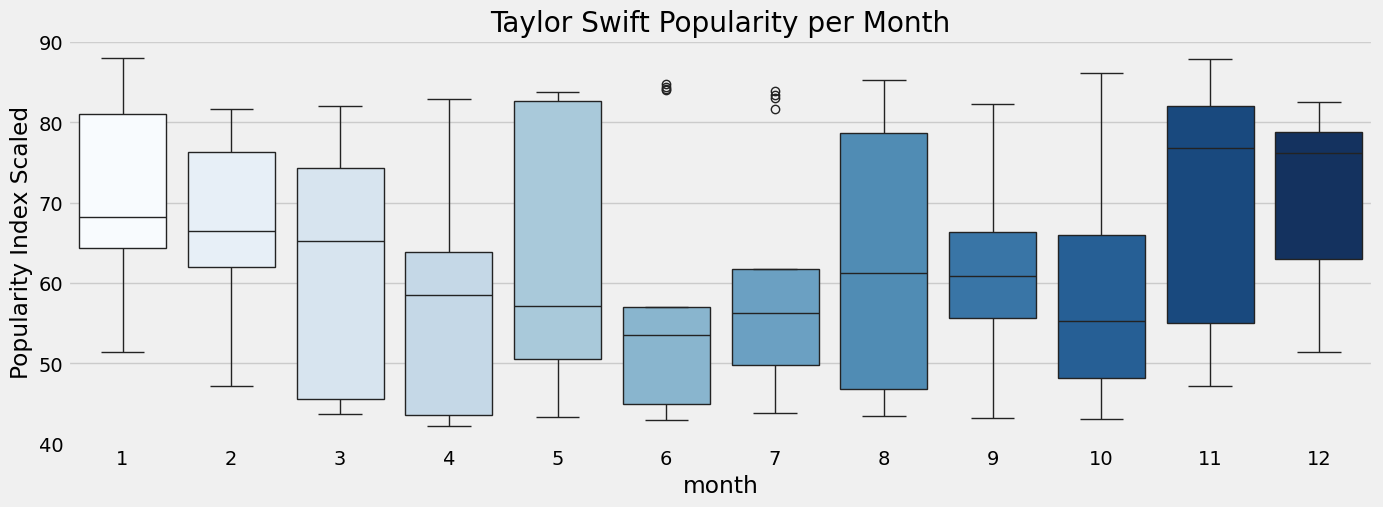

In [38]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df2, x='month', y='Popularity Index Scaled', hue='month' ,palette='Blues', legend=False)
ax.set_title('Taylor Swift Popularity per Month')
plt.show()

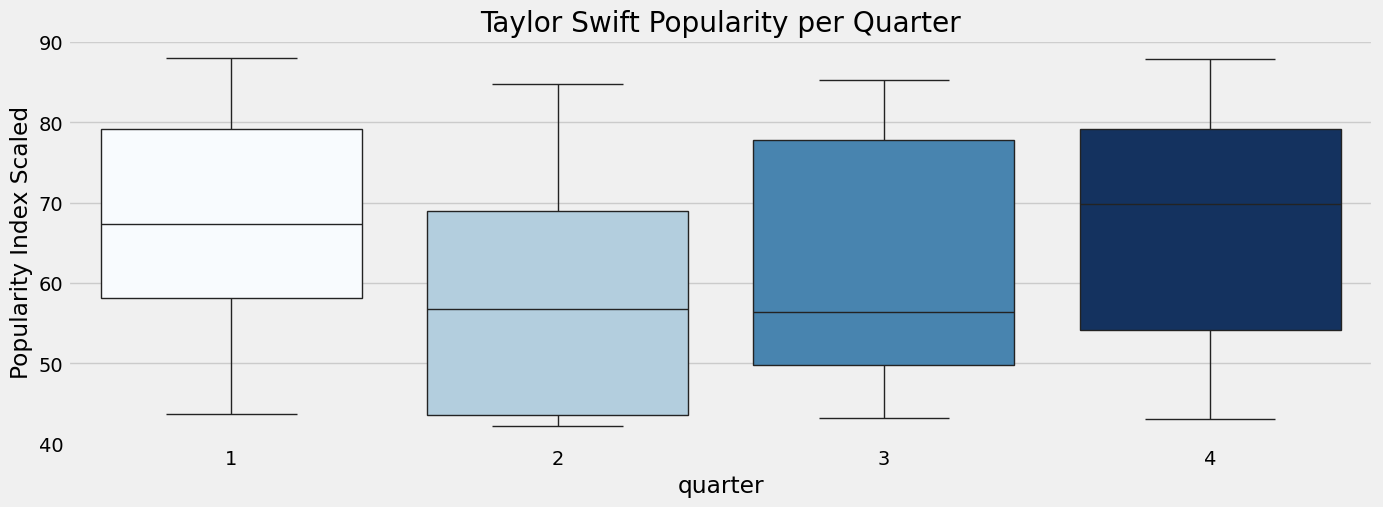

In [39]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df2, x='quarter', y='Popularity Index Scaled', hue='quarter' ,palette='Blues', legend=False)
ax.set_title('Taylor Swift Popularity per Quarter')
plt.show()

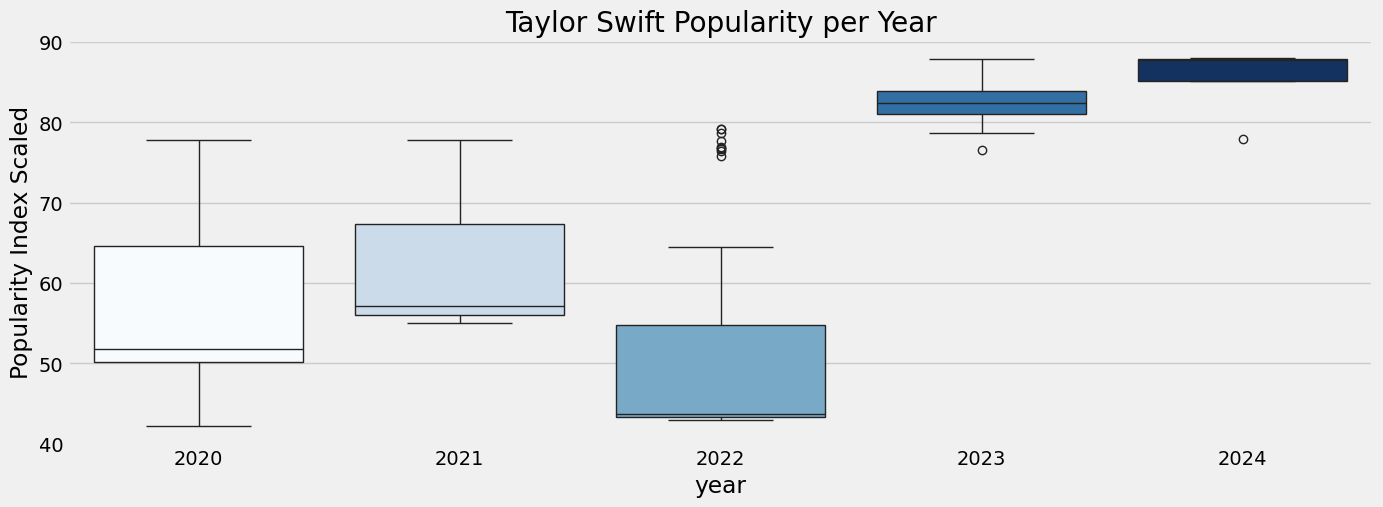

In [40]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df2, x='year', y='Popularity Index Scaled', hue='year' ,palette='Blues', legend=False)
ax.set_title('Taylor Swift Popularity per Year')
plt.show()

#### Creating the Model

You can specify hyperparameter values to the class constructor to configure the model.

Perhaps the most commonly configured hyperparameters are the following:

- ***n_estimators***: The number of trees in the ensemble, often increased until no further improvements are seen.
- ***max_depth***: The maximum depth of each tree, often values are between 1 and 10.
- ***eta***: The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.
- ***subsample***: The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.
- ***colsample_bytree***: Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.

In [41]:
taylor_swift_df =taylor_swift_df.set_index('Date').copy()

In [42]:
train = taylor_swift_df.loc[taylor_swift_df.index < '2023-06-01']
test = taylor_swift_df.loc[taylor_swift_df.index >= '2023-06-01']

In [43]:
FEATURES = ['Hot100 Rank', 'Digital Rank', 'Radio Rank', 'Streaming Rank',
       'Hot100 Peak Position', 'Digital Peak Position', 'Radio Peak Position',
       'Streaming Peak Position', 'Hot100 Weeks in Charts',
       'Digital Weeks in Charts', 'Radio Weeks in Charts',
       'Streaming Weeks in Charts']
TARGET = ['Popularity Index Scaled']

In [44]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [45]:
model = xgb.XGBRegressor(
    n_estimators=1000, 
    early_stopping_rounds=50, 
    learning_rate=0.01
    )

model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=True)

[0]	validation_0-rmse:12.70256	validation_1-rmse:23.42745
[1]	validation_0-rmse:12.58195	validation_1-rmse:23.24833
[2]	validation_0-rmse:12.46252	validation_1-rmse:23.07101
[3]	validation_0-rmse:12.34427	validation_1-rmse:22.89548
[4]	validation_0-rmse:12.22717	validation_1-rmse:22.72172
[5]	validation_0-rmse:12.11123	validation_1-rmse:22.54971
[6]	validation_0-rmse:11.99642	validation_1-rmse:22.37943
[7]	validation_0-rmse:11.88275	validation_1-rmse:22.21088
[8]	validation_0-rmse:11.77019	validation_1-rmse:22.04402
[9]	validation_0-rmse:11.65874	validation_1-rmse:21.87885
[10]	validation_0-rmse:11.54838	validation_1-rmse:21.71535
[11]	validation_0-rmse:11.43912	validation_1-rmse:21.55479
[12]	validation_0-rmse:11.33092	validation_1-rmse:21.39458
[13]	validation_0-rmse:11.22377	validation_1-rmse:21.23727
[14]	validation_0-rmse:11.11769	validation_1-rmse:21.08191
[15]	validation_0-rmse:11.01265	validation_1-rmse:20.92778
[16]	validation_0-rmse:10.90863	validation_1-rmse:20.77555
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [46]:
model.feature_importances_

array([6.8564594e-01, 1.3193766e-03, 2.4108756e-03, 1.1735386e-03,
       8.0969810e-02, 2.1580163e-01, 3.5498594e-04, 8.5081690e-04,
       7.3232283e-03, 2.6970783e-03, 1.4029708e-03, 4.9696650e-05],
      dtype=float32)

In [47]:
fi2 = pd.DataFrame(
        data = model.feature_importances_,
        index = model.feature_names_in_,
        columns=['Taylor Swift score']
        )
fi2

Taylor Swift score
Hot100 Rank                          0.685646
Digital Rank                         0.001319
Radio Rank                           0.002411
Streaming Rank                       0.001174
Hot100 Peak Position                 0.080970
Digital Peak Position                0.215802
Radio Peak Position                  0.000355
Streaming Peak Position              0.000851
Hot100 Weeks in Charts               0.007323
Digital Weeks in Charts              0.002697
Radio Weeks in Charts                0.001403
Streaming Weeks in Charts            0.000050

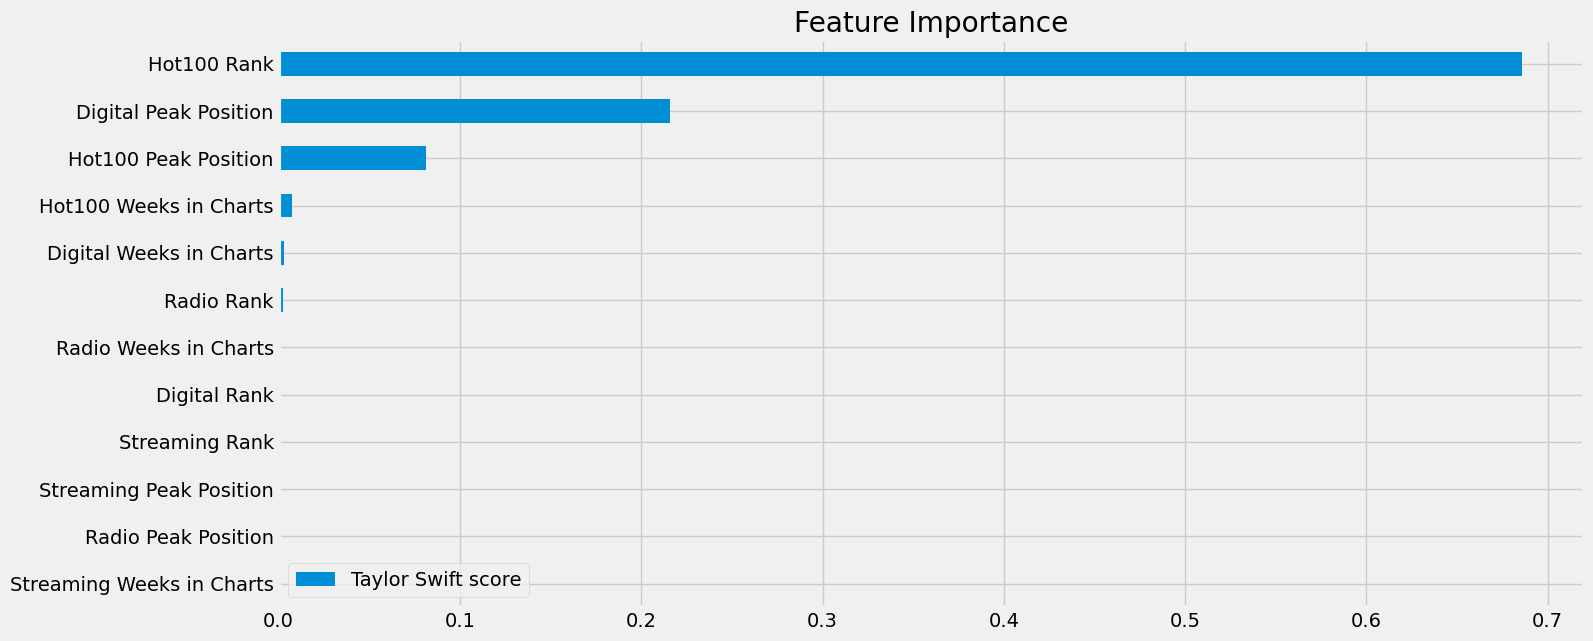

In [48]:
fi2.sort_values(by='Taylor Swift score').plot(kind='barh', title='Feature Importance')
plt.show()

#### Predicting

In [49]:
model.predict(X_test)

array([83.00692 , 83.00605 , 81.90965 , 83.00692 , 81.90965 , 81.909935,
       81.910324, 80.88886 , 69.50408 , 68.99735 , 81.55835 , 81.637115,
       80.88886 , 66.19862 , 81.097916, 80.75979 , 69.40148 , 81.13601 ,
       80.8835  , 81.006256, 82.916435, 81.09366 , 82.55408 , 82.742615,
       83.13308 , 83.69081 , 83.728615, 82.56131 , 82.15003 , 82.15003 ,
       82.14599 , 83.71329 , 83.45886 , 83.72737 ], dtype=float32)

In [50]:
test['Prediction'] = model.predict(X_test)

/var/folders/9f/0437b_tn3hd136wm5vpp7y7h0000gn/T/ipykernel_15918/763973304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = model.predict(X_test)


- Now I have a prediction in the dataframe

In [51]:
df2 = df2.merge(test[['Prediction']], how='left', left_index=True, right_index=True)
df2

Popularity Index Scaled  quarter  month  year  Prediction
Date                                                                 
2020-01-01                64.283302        1      1  2020         NaN
2020-01-08                68.654060        1      1  2020         NaN
2020-01-15                68.264587        1      1  2020         NaN
2020-01-22                64.316960        1      1  2020         NaN
2020-01-29                65.601737        1      1  2020         NaN
...                             ...      ...    ...   ...         ...
2023-12-27                79.191750        4     12  2023   82.150032
2024-01-03                77.920218        1      1  2024   82.145988
2024-01-10                87.995240        1      1  2024   83.713287
2024-01-17                87.826949        1      1  2024   83.458862
2024-01-24                87.557684        1      1  2024   83.727371

[213 rows x 5 columns]

<Axes: xlabel='Date'>

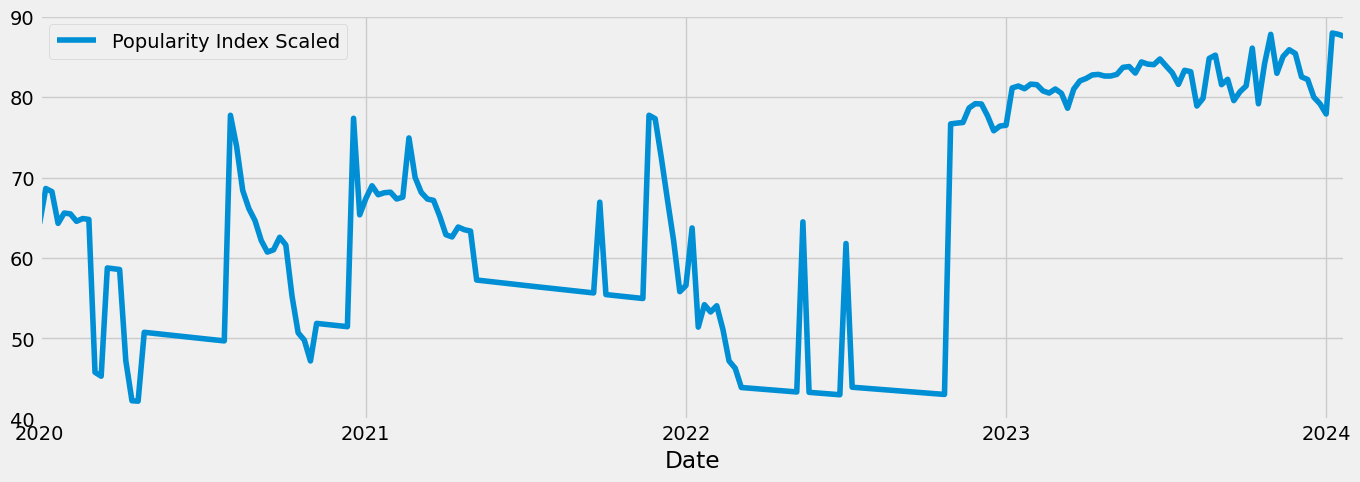

In [52]:
ax = df2[['Popularity Index Scaled']].plot(figsize=(15, 5))
ax

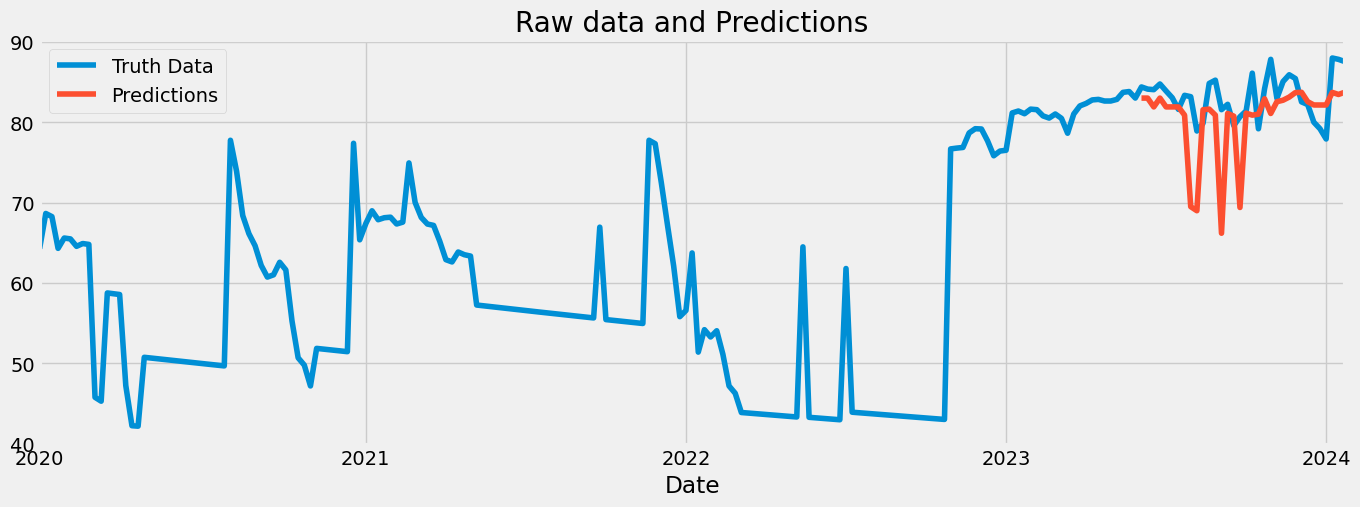

In [53]:
ax = df2[['Popularity Index Scaled']].plot(figsize=(15, 5))
df2['Prediction'].plot(ax=ax, style='-')
ax.set_title('Raw data and Predictions')
plt.legend(['Truth Data','Predictions'])
plt.show()

#### Score

In [54]:
score = root_mean_squared_error(test['Popularity Index Scaled'],test['Prediction'])
print(f'RMSE Score on test set : {score:0.2f}')

RMSE Score on test set : 5.10


## 3. The Weeknd Vs Billie Eilish

In [55]:
artist_name3 = 'The Weeknd'
artist_name4 = 'Billie Eilish'
columns_to_calculate = ['Hot100 Rank', 'Digital Rank', 'Radio Rank','Streaming Rank', 'Hot100 Peak Position', 'Digital Peak Position',
       'Radio Peak Position', 'Streaming Peak Position','Hot100 Weeks in Charts', 'Digital Weeks in Charts',
       'Radio Weeks in Charts', 'Streaming Weeks in Charts','Popularity Index Scaled']  # Add other columns as needed


In [56]:
# Creating a dataframe only for an artist
weeknd_df = create_artist_popularity_df(artist_name3, pan_df, target_columns=columns_to_calculate)
billie_df = create_artist_popularity_df(artist_name4, pan_df, target_columns=columns_to_calculate)

In [57]:
weeknd_plot_df = weeknd_df[['Date','Popularity Index Scaled']]
billie_plot_df = billie_df[['Date','Popularity Index Scaled']]

<Axes: xlabel='Date'>

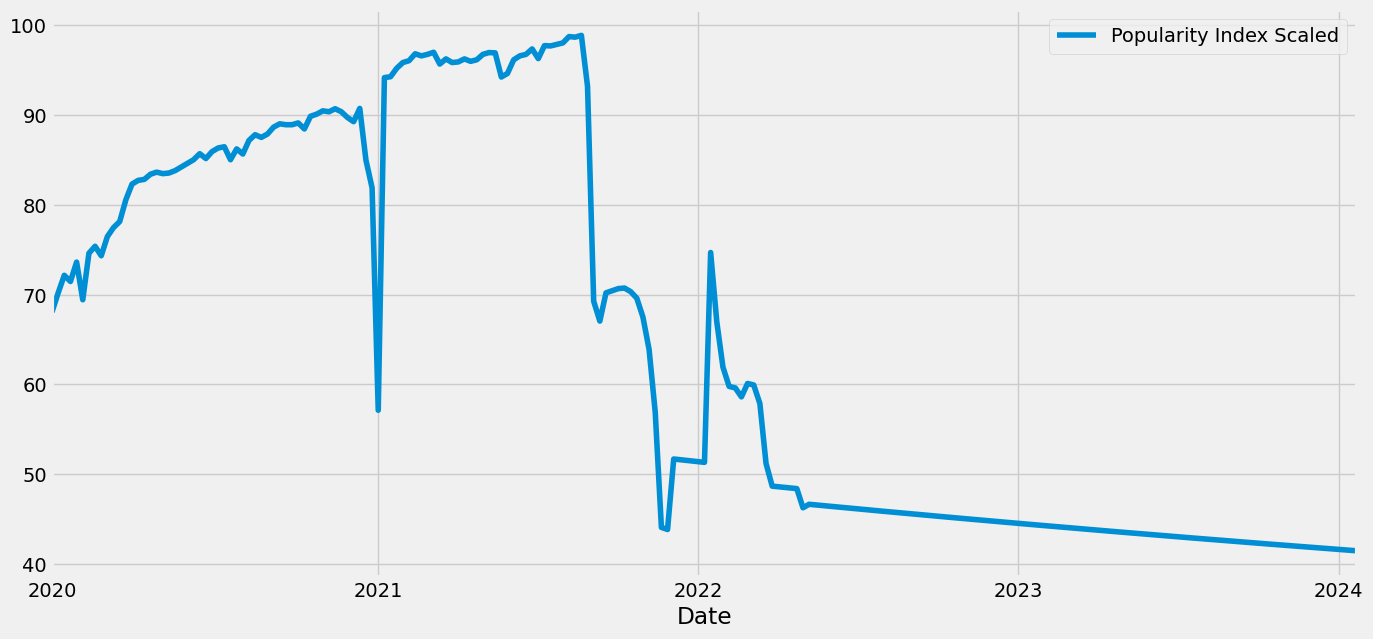

In [58]:
weeknd_plot_df.columns=["Date","Popularity Index Scaled"]
weeknd_plot_df.set_index('Date',inplace=True)

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7
weeknd_plot_df.plot()

<Axes: xlabel='Date'>

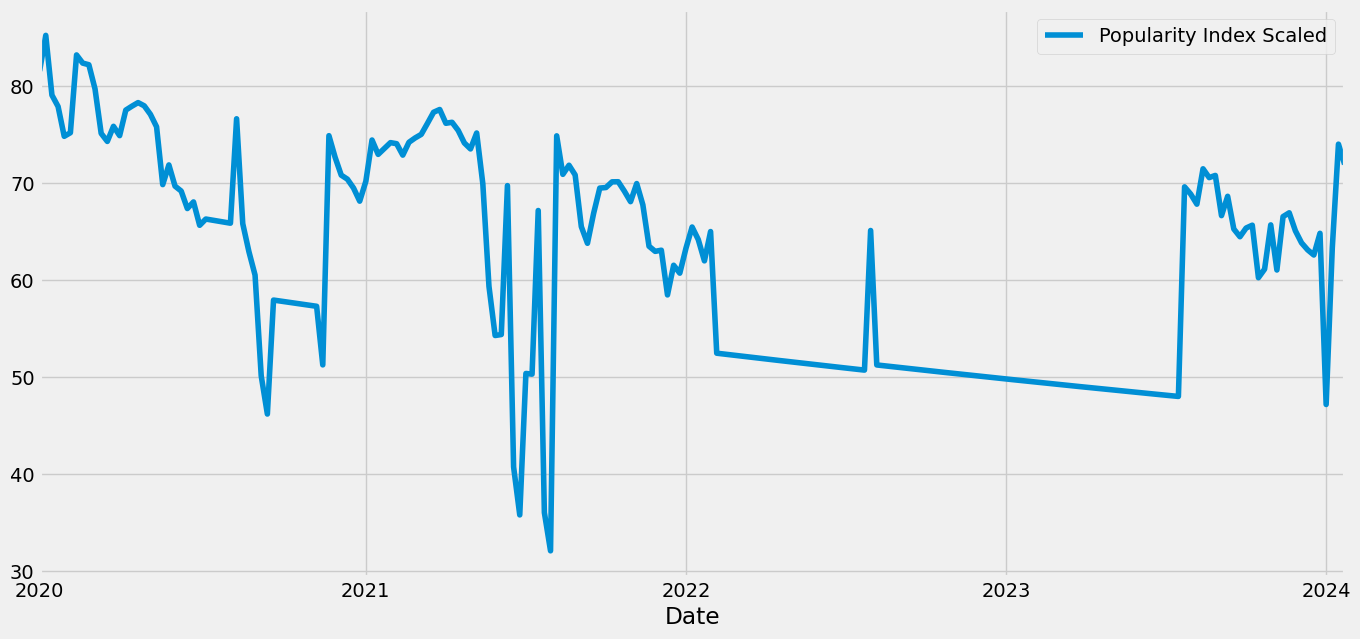

In [59]:
billie_plot_df.columns=["Date","Popularity Index Scaled"]
billie_plot_df.set_index('Date',inplace=True)

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7
billie_plot_df.plot()

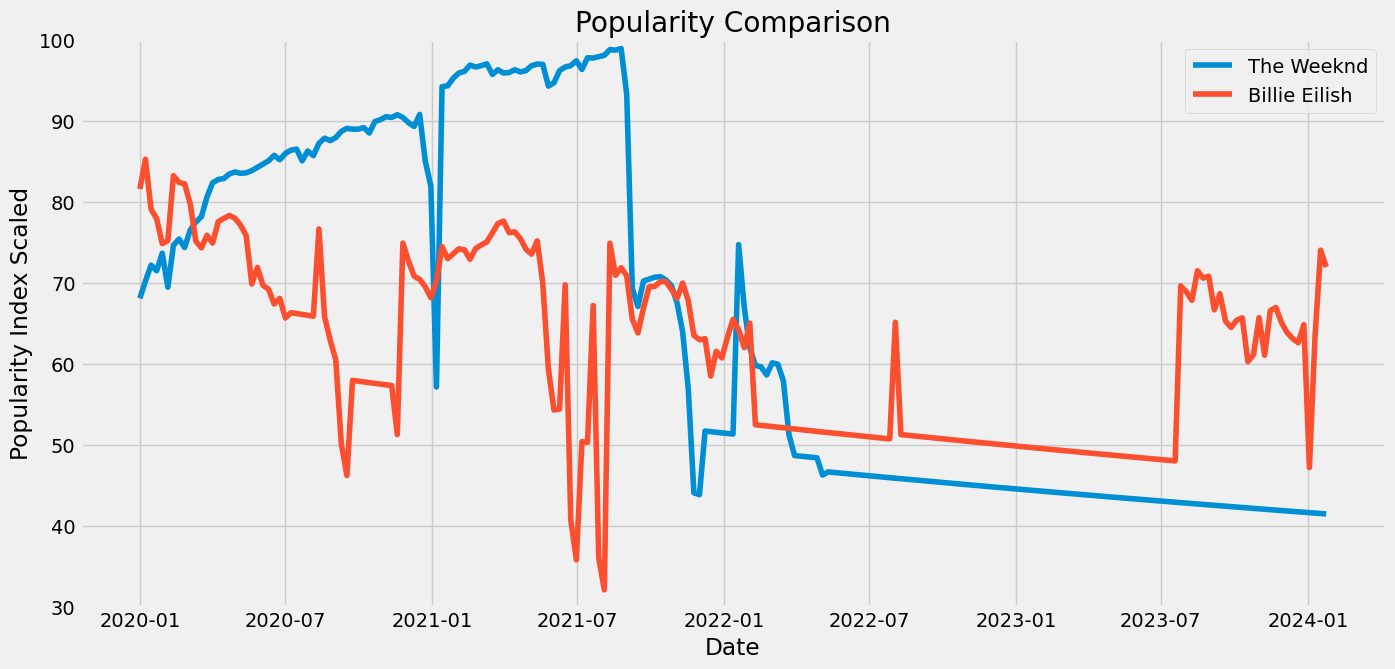

In [60]:
# Set the figure size
rcParams['figure.figsize'] = 15, 7

# Plot for Dua Lipa
plt.plot(weeknd_plot_df.index, weeknd_plot_df['Popularity Index Scaled'], label='The Weeknd')

# Plot for Taylor Swift
plt.plot(billie_plot_df.index, billie_plot_df['Popularity Index Scaled'], label='Billie Eilish')

# Set y-axis limits
plt.ylim(30, 100)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Popularity Index Scaled')
plt.title('Popularity Comparison')
plt.legend()

# Show the combined plot
plt.show()



In [61]:
weeknd_plot_df

Popularity Index Scaled
Date                               
2020-01-01                68.058364
2020-01-08                70.183817
2020-01-15                72.154692
2020-01-22                71.464075
2020-01-29                73.623187
...                             ...
2023-12-27                41.645957
2024-01-03                41.593719
2024-01-10                41.541612
2024-01-17                41.489636
2024-01-24                41.437789

[213 rows x 1 columns]

### 3.1. The Weeknd Predictive Modelling with XCBoost

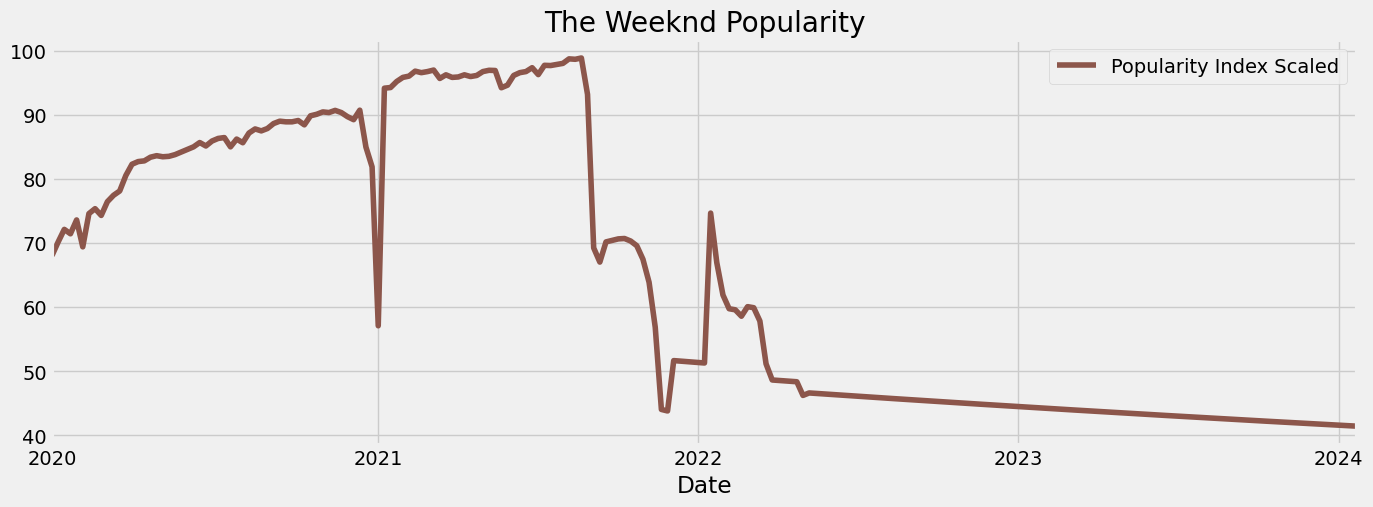

In [62]:
weeknd_plot_df.plot(style='-',
        figsize=(15, 5), 
        color=color_pal[5], 
        title='The Weeknd Popularity')
plt.show()

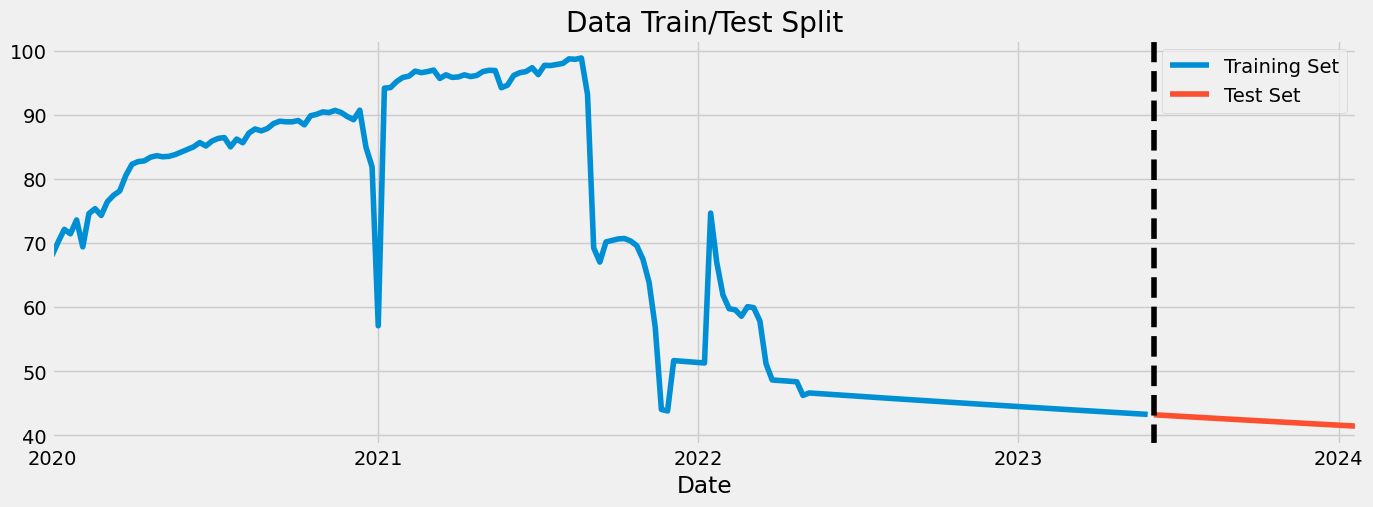

In [63]:
train = weeknd_plot_df.loc[weeknd_plot_df.index < '2023-06-01']
test = weeknd_plot_df.loc[weeknd_plot_df.index >= '2023-06-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label= 'Test Set')
ax.axvline('2023-06-01', color='black', ls='--')
ax.legend(['Training Set','Test Set'])
plt.show()

In [64]:
def create_features(df):
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

df3 = create_features(weeknd_plot_df)

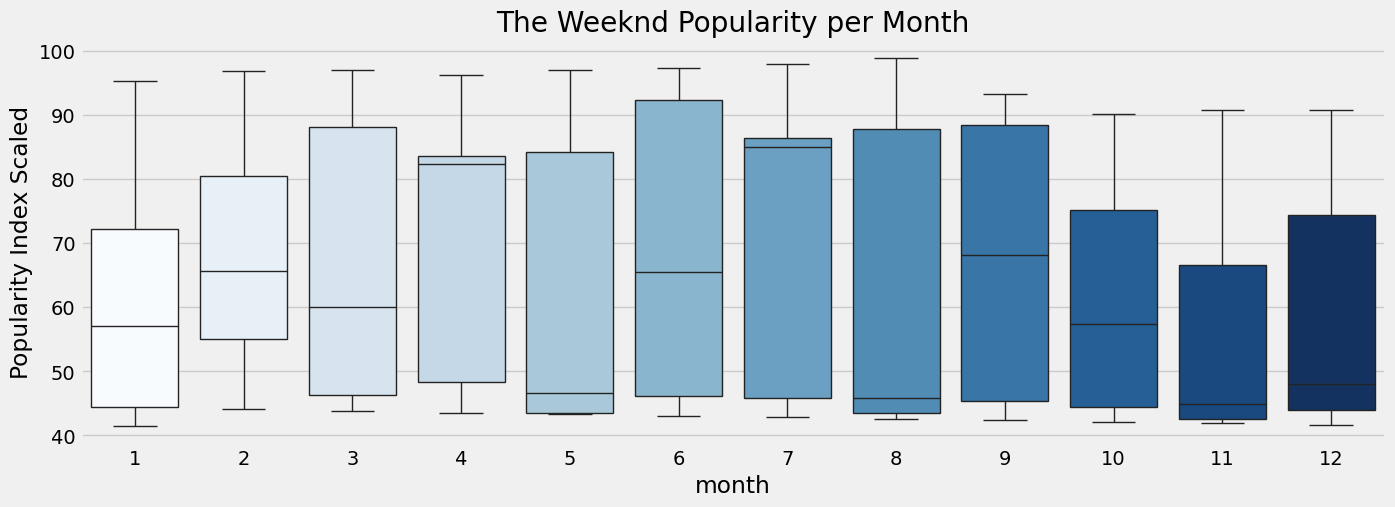

In [65]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df3, x='month', y='Popularity Index Scaled', hue='month' ,palette='Blues', legend=False)
ax.set_title('The Weeknd Popularity per Month')
plt.show()

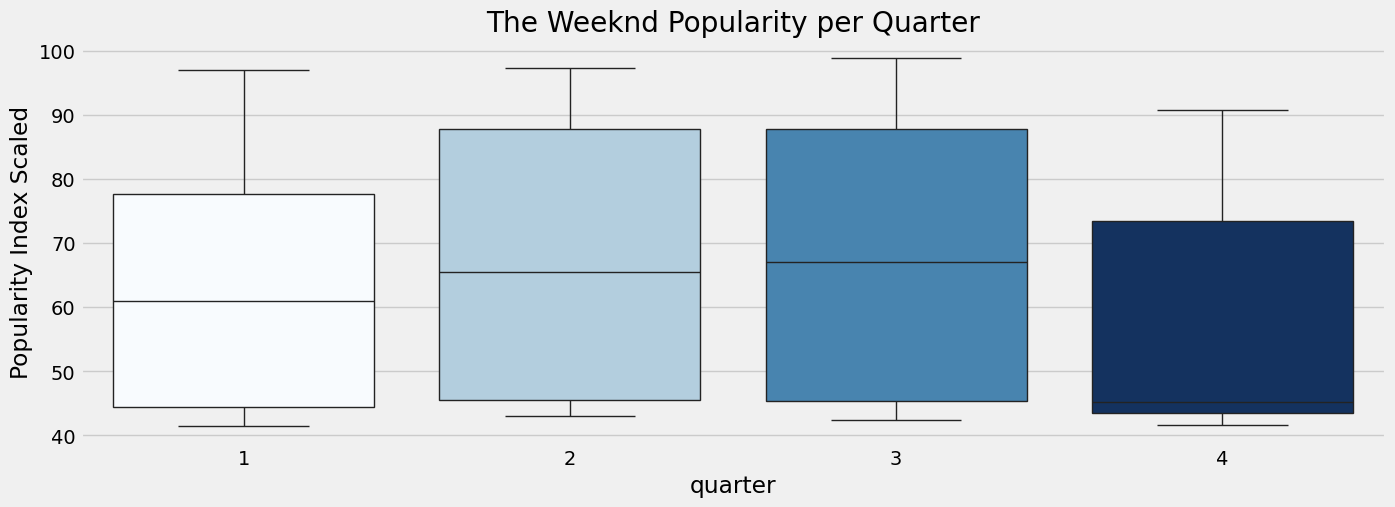

In [66]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df3, x='quarter', y='Popularity Index Scaled', hue='quarter' ,palette='Blues', legend=False)
ax.set_title('The Weeknd Popularity per Quarter')
plt.show()

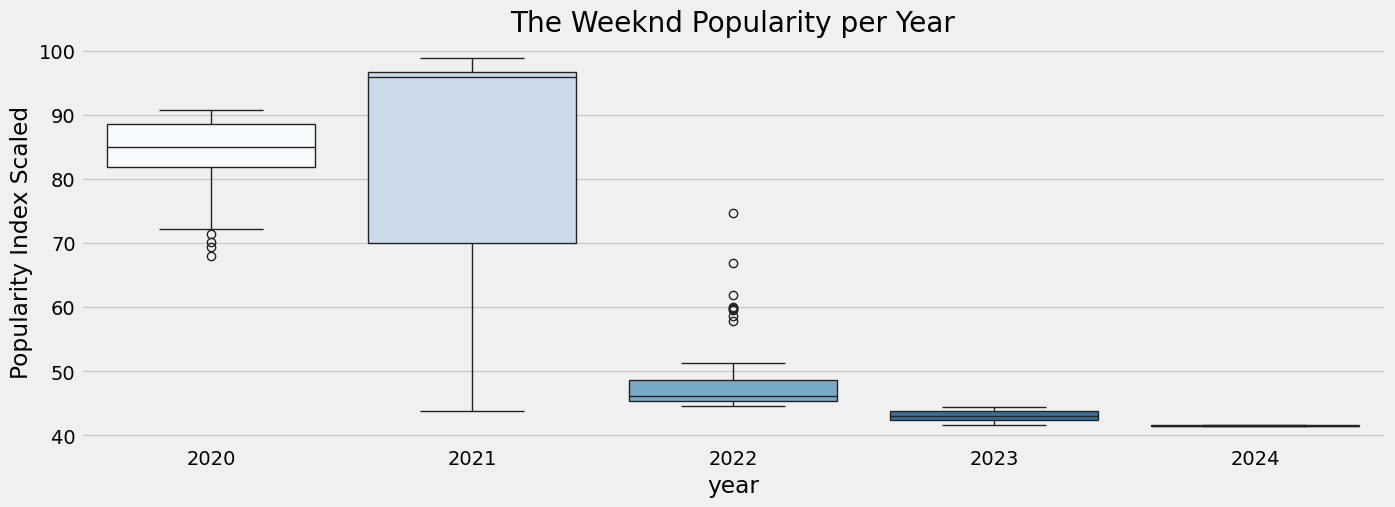

In [67]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df3, x='year', y='Popularity Index Scaled', hue='year' ,palette='Blues', legend=False)
ax.set_title('The Weeknd Popularity per Year')
plt.show()

#### Creating the Model

You can specify hyperparameter values to the class constructor to configure the model.

Perhaps the most commonly configured hyperparameters are the following:

- ***n_estimators***: The number of trees in the ensemble, often increased until no further improvements are seen.
- ***max_depth***: The maximum depth of each tree, often values are between 1 and 10.
- ***eta***: The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.
- ***subsample***: The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.
- ***colsample_bytree***: Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.

In [68]:
weeknd_df = weeknd_df.set_index('Date').copy()

In [69]:
train = weeknd_df.loc[weeknd_df.index < '2023-06-01']
test = weeknd_df.loc[weeknd_df.index >= '2023-06-01']

In [70]:
FEATURES = ['Hot100 Rank', 'Digital Rank', 'Radio Rank', 'Streaming Rank',
       'Hot100 Peak Position', 'Digital Peak Position', 'Radio Peak Position',
       'Streaming Peak Position', 'Hot100 Weeks in Charts',
       'Digital Weeks in Charts', 'Radio Weeks in Charts',
       'Streaming Weeks in Charts']
TARGET = ['Popularity Index Scaled']

In [71]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [72]:
model = xgb.XGBRegressor(
    n_estimators=1000, 
    early_stopping_rounds=50, 
    learning_rate=0.01
    )

model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=True)

[0]	validation_0-rmse:20.74759	validation_1-rmse:26.30570
[1]	validation_0-rmse:20.54734	validation_1-rmse:26.07499
[2]	validation_0-rmse:20.34907	validation_1-rmse:25.84655
[3]	validation_0-rmse:20.15275	validation_1-rmse:25.62035
[4]	validation_0-rmse:19.95837	validation_1-rmse:25.39639
[5]	validation_0-rmse:19.76585	validation_1-rmse:25.17463
[6]	validation_0-rmse:19.57522	validation_1-rmse:24.95506
[7]	validation_0-rmse:19.38646	validation_1-rmse:24.73765
[8]	validation_0-rmse:19.19954	validation_1-rmse:24.52238
[9]	validation_0-rmse:19.01451	validation_1-rmse:24.30923
[10]	validation_0-rmse:18.83123	validation_1-rmse:24.09819
[11]	validation_0-rmse:18.64975	validation_1-rmse:23.88921
[12]	validation_0-rmse:18.47000	validation_1-rmse:23.68230
[13]	validation_0-rmse:18.29206	validation_1-rmse:23.47743
[14]	validation_0-rmse:18.11585	validation_1-rmse:23.27457
[15]	validation_0-rmse:17.94137	validation_1-rmse:23.07371
[16]	validation_0-rmse:17.76856	validation_1-rmse:22.87483
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [73]:
model.feature_importances_

array([4.8778197e-01, 4.7577065e-05, 1.1141412e-02, 5.8893650e-04,
       4.7326550e-02, 4.1176924e-03, 3.2320558e-04, 5.0666591e-04,
       9.8937191e-02, 6.8699429e-03, 1.1519182e-01, 2.2716701e-01],
      dtype=float32)

In [74]:
fi3 = pd.DataFrame(
        data = model.feature_importances_,
        index = model.feature_names_in_,
        columns=['Weeknd score']
        )
fi3

Weeknd score
Hot100 Rank                    0.487782
Digital Rank                   0.000048
Radio Rank                     0.011141
Streaming Rank                 0.000589
Hot100 Peak Position           0.047327
Digital Peak Position          0.004118
Radio Peak Position            0.000323
Streaming Peak Position        0.000507
Hot100 Weeks in Charts         0.098937
Digital Weeks in Charts        0.006870
Radio Weeks in Charts          0.115192
Streaming Weeks in Charts      0.227167

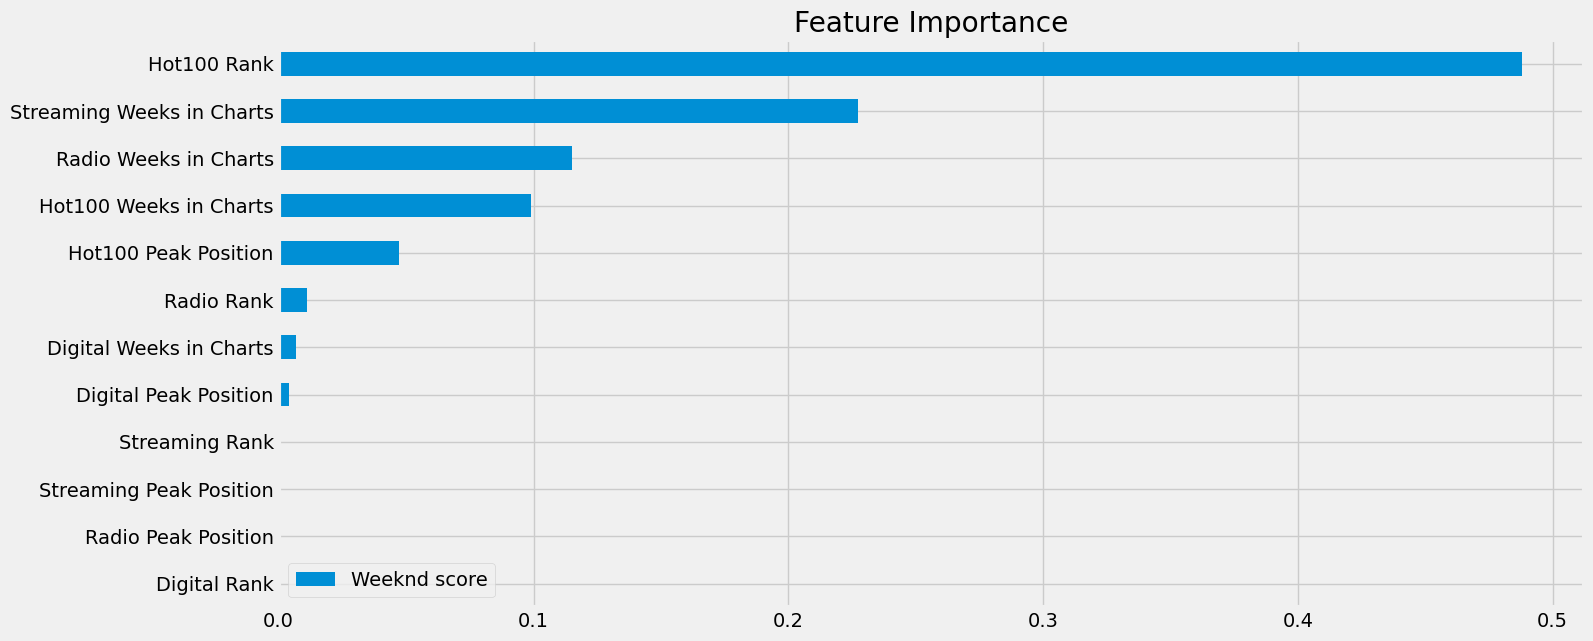

In [75]:
fi3.sort_values(by='Weeknd score').plot(kind='barh', title='Feature Importance')
plt.show()

#### Predicting

In [76]:
model.predict(X_test)

array([43.836613, 43.836613, 43.836613, 43.836613, 43.836613, 43.836613,
       43.836613, 43.836613, 43.836613, 43.836613, 43.836613, 43.836613,
       43.836613, 43.836613, 43.836613, 43.836613, 43.836613, 43.836613,
       43.836613, 43.836613, 43.836613, 43.836613, 43.836613, 43.836613,
       43.836613, 43.836613, 43.836613, 43.836613, 43.836613, 43.836613,
       43.836613, 43.836613, 43.836613, 43.836613], dtype=float32)

In [77]:
test['Prediction'] = model.predict(X_test)

/var/folders/9f/0437b_tn3hd136wm5vpp7y7h0000gn/T/ipykernel_15918/763973304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = model.predict(X_test)


- Now I have a prediction in the dataframe

In [78]:
df3 = df3.merge(test[['Prediction']], how='left', left_index=True, right_index=True)
df3

Popularity Index Scaled  quarter  month  year  Prediction
Date                                                                 
2020-01-01                68.058364        1      1  2020         NaN
2020-01-08                70.183817        1      1  2020         NaN
2020-01-15                72.154692        1      1  2020         NaN
2020-01-22                71.464075        1      1  2020         NaN
2020-01-29                73.623187        1      1  2020         NaN
...                             ...      ...    ...   ...         ...
2023-12-27                41.645957        4     12  2023   43.836613
2024-01-03                41.593719        1      1  2024   43.836613
2024-01-10                41.541612        1      1  2024   43.836613
2024-01-17                41.489636        1      1  2024   43.836613
2024-01-24                41.437789        1      1  2024   43.836613

[213 rows x 5 columns]

<Axes: xlabel='Date'>

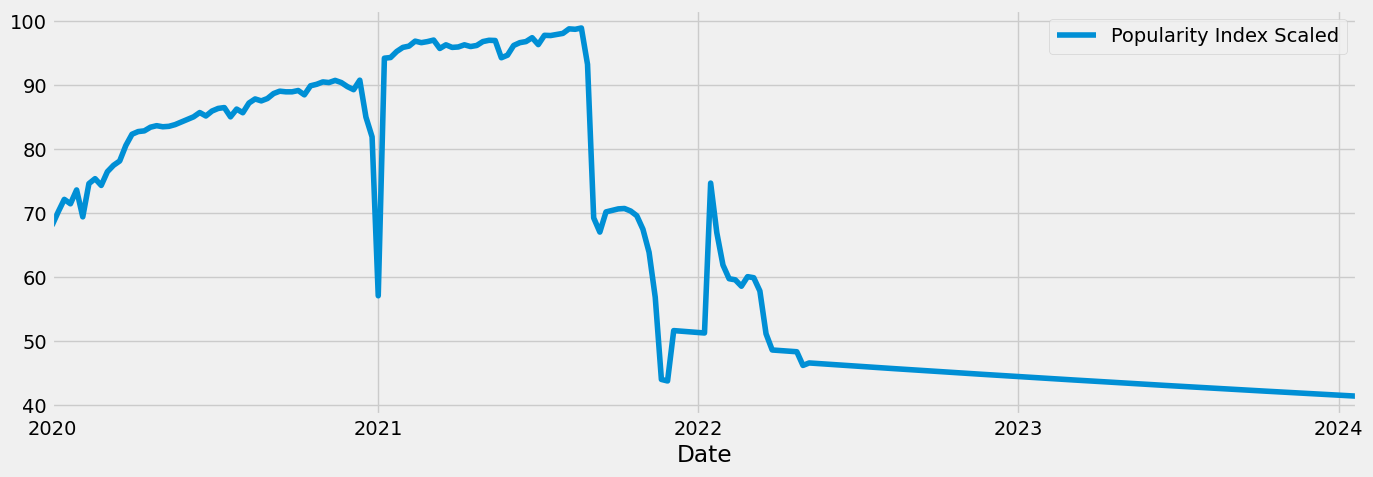

In [79]:
ax = df3[['Popularity Index Scaled']].plot(figsize=(15, 5))
ax

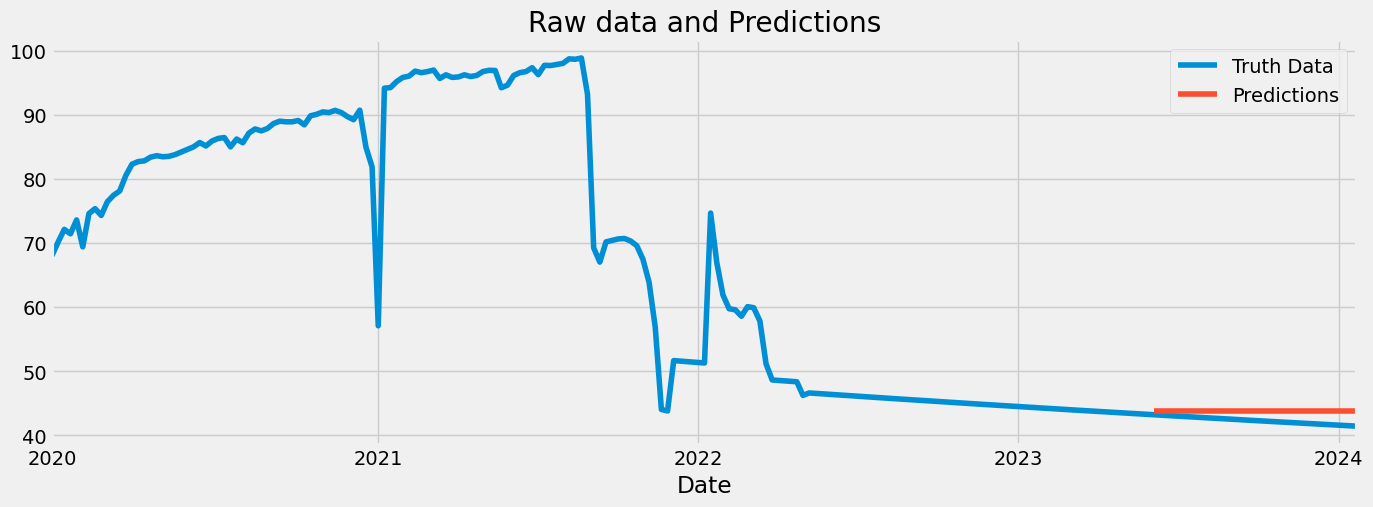

In [80]:
ax = df3[['Popularity Index Scaled']].plot(figsize=(15, 5))
df3['Prediction'].plot(ax=ax, style='-')
ax.set_title('Raw data and Predictions')
plt.legend(['Truth Data','Predictions'])
plt.show()

#### Score

In [81]:
score = root_mean_squared_error(test['Popularity Index Scaled'],test['Prediction'])
print(f'RMSE Score on test set : {score:0.2f}')

RMSE Score on test set : 1.61


---

### 3.3. Billie Eilish Predictive Modelling with XCBoost

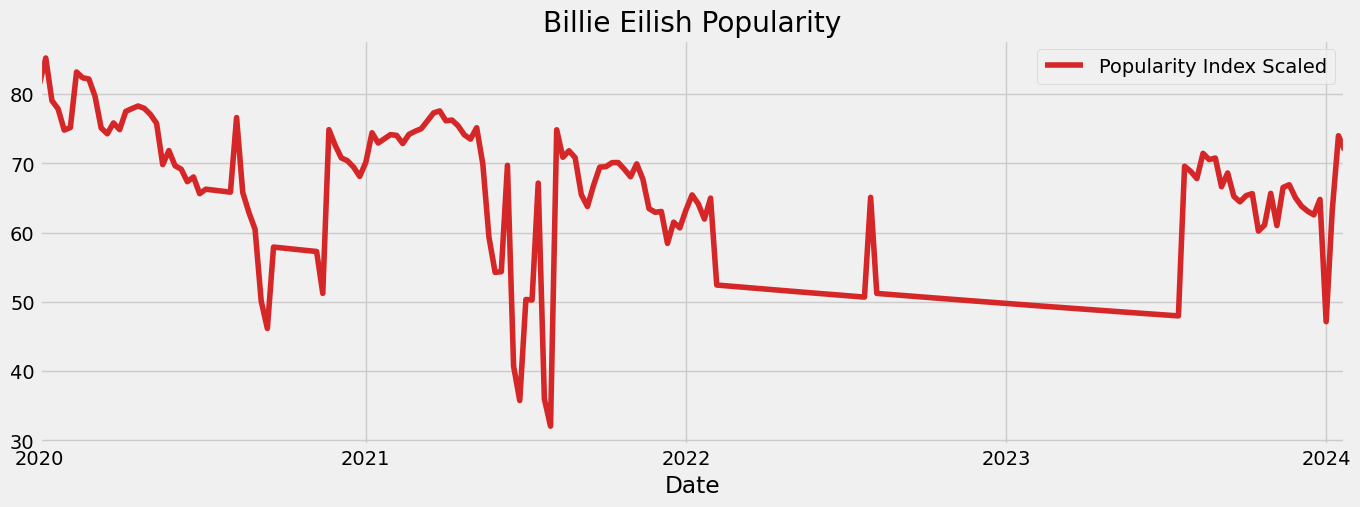

In [82]:
billie_plot_df.plot(style='-',
        figsize=(15, 5), 
        color=color_pal[3], 
        title='Billie Eilish Popularity')
plt.show()

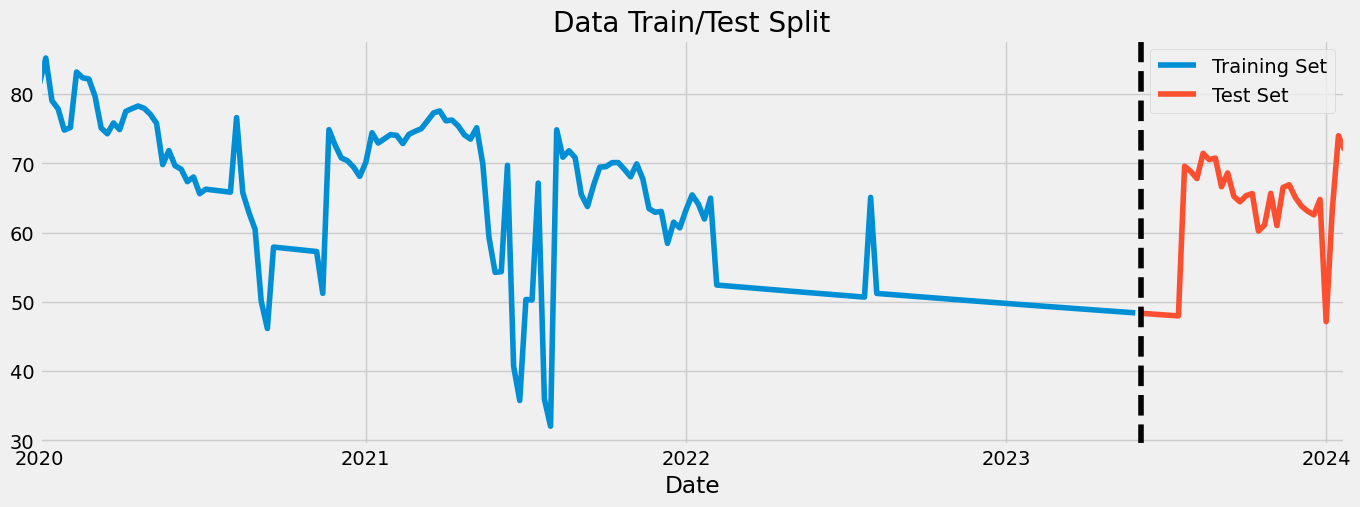

In [83]:
train = billie_plot_df.loc[billie_plot_df.index < '2023-06-01']
test = billie_plot_df.loc[billie_plot_df.index >= '2023-06-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label= 'Test Set')
ax.axvline('2023-06-01', color='black', ls='--')
ax.legend(['Training Set','Test Set'])
plt.show()

In [84]:
def create_features(df):
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

df4 = create_features(billie_plot_df)

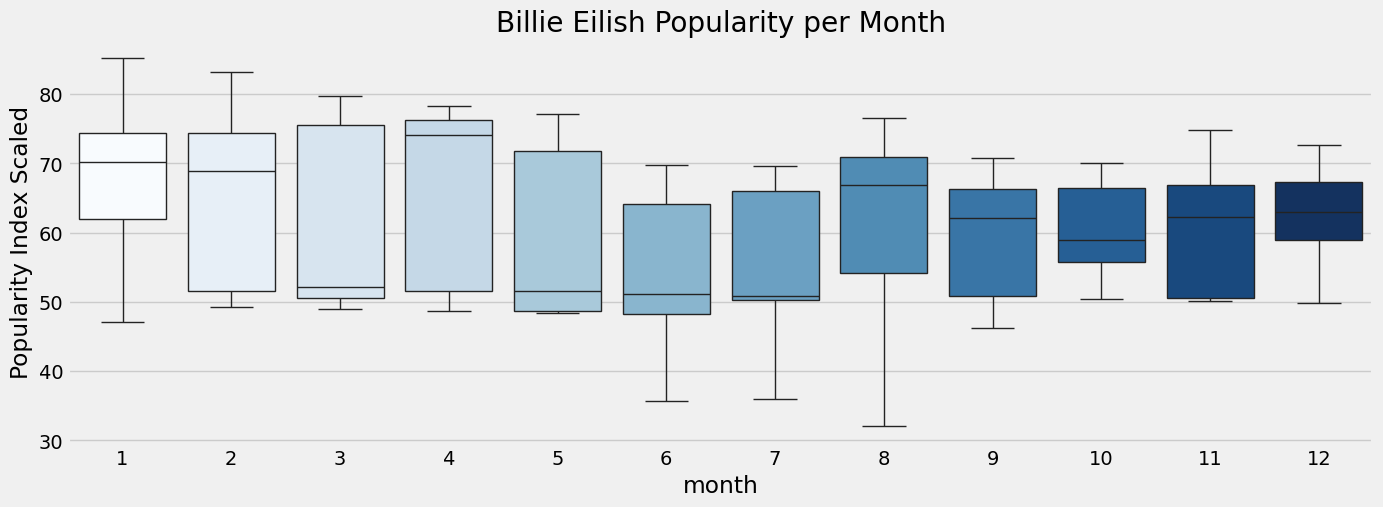

In [85]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df4, x='month', y='Popularity Index Scaled', hue='month' ,palette='Blues', legend=False)
ax.set_title('Billie Eilish Popularity per Month')
plt.show()

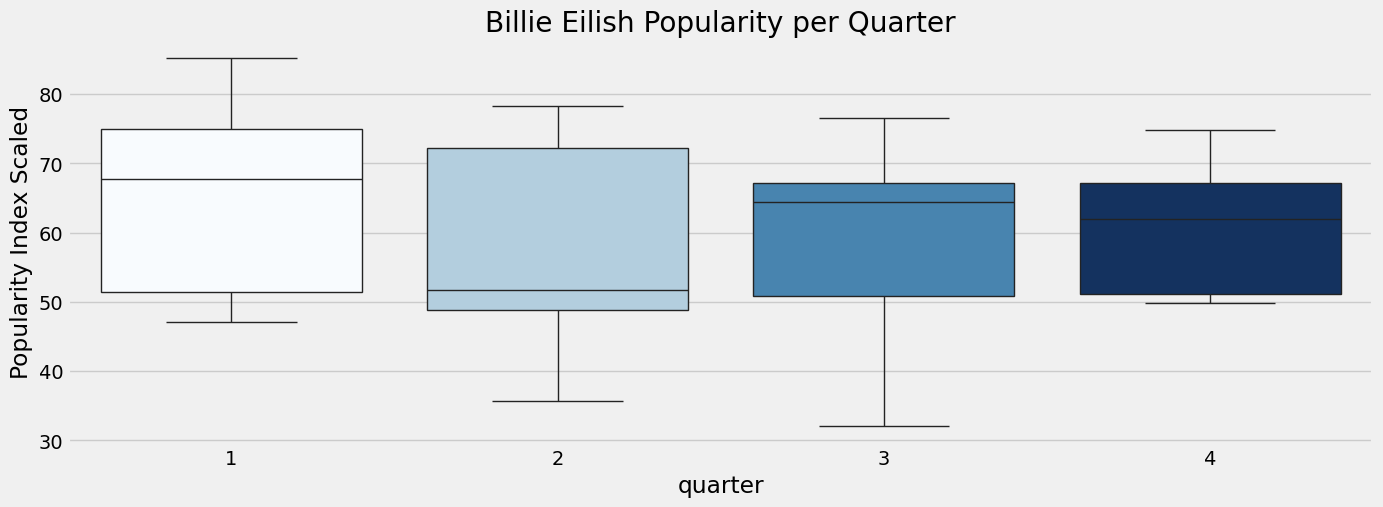

In [86]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df4, x='quarter', y='Popularity Index Scaled', hue='quarter' ,palette='Blues', legend=False)
ax.set_title('Billie Eilish Popularity per Quarter')
plt.show()

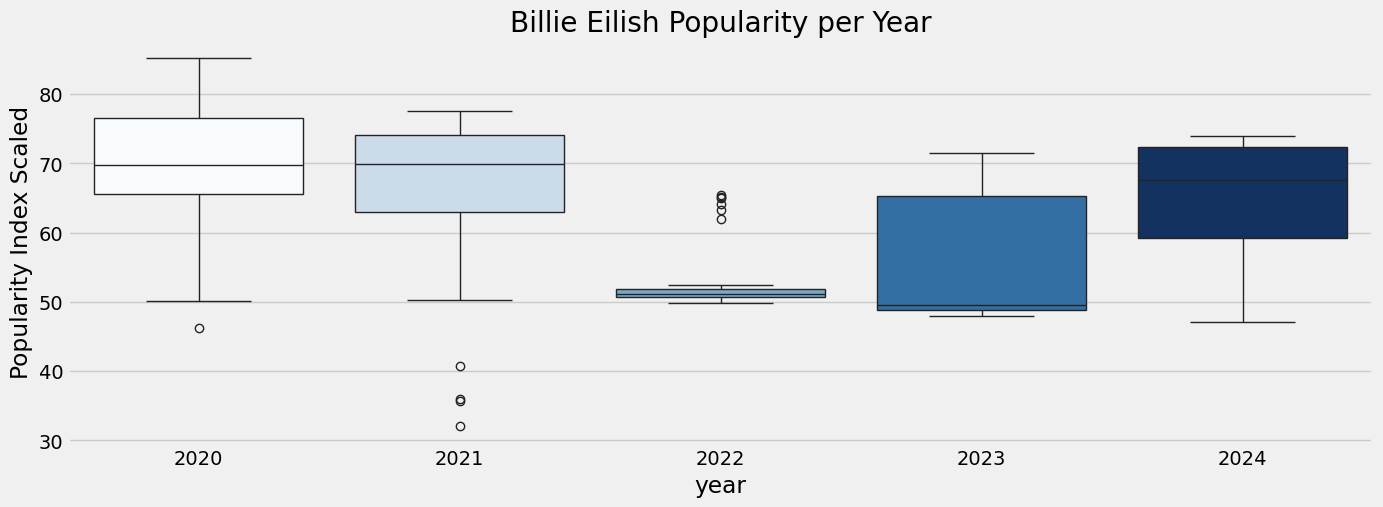

In [87]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df4, x='year', y='Popularity Index Scaled', hue='year' ,palette='Blues', legend=False)
ax.set_title('Billie Eilish Popularity per Year')
plt.show()

#### Creating the Model

You can specify hyperparameter values to the class constructor to configure the model.

Perhaps the most commonly configured hyperparameters are the following:

- ***n_estimators***: The number of trees in the ensemble, often increased until no further improvements are seen.
- ***max_depth***: The maximum depth of each tree, often values are between 1 and 10.
- ***eta***: The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.
- ***subsample***: The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.
- ***colsample_bytree***: Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.

In [88]:
billie_df =billie_df.set_index('Date').copy()

In [89]:
train = billie_df.loc[billie_df.index < '2023-06-01']
test = billie_df.loc[billie_df.index >= '2023-06-01']

In [90]:
FEATURES = ['Hot100 Rank', 'Digital Rank', 'Radio Rank', 'Streaming Rank',
       'Hot100 Peak Position', 'Digital Peak Position', 'Radio Peak Position',
       'Streaming Peak Position', 'Hot100 Weeks in Charts',
       'Digital Weeks in Charts', 'Radio Weeks in Charts',
       'Streaming Weeks in Charts']
TARGET = ['Popularity Index Scaled']

In [91]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [92]:
model = xgb.XGBRegressor(
    n_estimators=1000, 
    early_stopping_rounds=50, 
    learning_rate=0.01
    )

model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=True)

[0]	validation_0-rmse:11.38725	validation_1-rmse:8.39517
[1]	validation_0-rmse:11.28290	validation_1-rmse:8.38585
[2]	validation_0-rmse:11.17957	validation_1-rmse:8.37616
[3]	validation_0-rmse:11.07724	validation_1-rmse:8.36813
[4]	validation_0-rmse:10.97590	validation_1-rmse:8.35963
[5]	validation_0-rmse:10.87553	validation_1-rmse:8.35279
[6]	validation_0-rmse:10.77614	validation_1-rmse:8.34544
[7]	validation_0-rmse:10.67763	validation_1-rmse:8.33855
[8]	validation_0-rmse:10.58007	validation_1-rmse:8.33336
[9]	validation_0-rmse:10.48345	validation_1-rmse:8.32748
[10]	validation_0-rmse:10.38776	validation_1-rmse:8.32335
[11]	validation_0-rmse:10.29305	validation_1-rmse:8.31850
[12]	validation_0-rmse:10.19918	validation_1-rmse:8.31524
[13]	validation_0-rmse:10.10622	validation_1-rmse:8.31126
[14]	validation_0-rmse:10.01414	validation_1-rmse:8.30758
[15]	validation_0-rmse:9.92295	validation_1-rmse:8.30580
[16]	validation_0-rmse:9.83263	validation_1-rmse:8.30314
[17]	validation_0-rmse:9.7

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [93]:
model.feature_importances_

array([0.45538202, 0.0007878 , 0.00276219, 0.0818711 , 0.03350069,
       0.11548678, 0.00056824, 0.0515309 , 0.2520801 , 0.00249681,
       0.        , 0.00353337], dtype=float32)

In [94]:
fi4 = pd.DataFrame(
        data = model.feature_importances_,
        index = model.feature_names_in_,
        columns=['Billie Eilish score']
        )
fi4

Billie Eilish score
Hot100 Rank                           0.455382
Digital Rank                          0.000788
Radio Rank                            0.002762
Streaming Rank                        0.081871
Hot100 Peak Position                  0.033501
Digital Peak Position                 0.115487
Radio Peak Position                   0.000568
Streaming Peak Position               0.051531
Hot100 Weeks in Charts                0.252080
Digital Weeks in Charts               0.002497
Radio Weeks in Charts                 0.000000
Streaming Weeks in Charts             0.003533

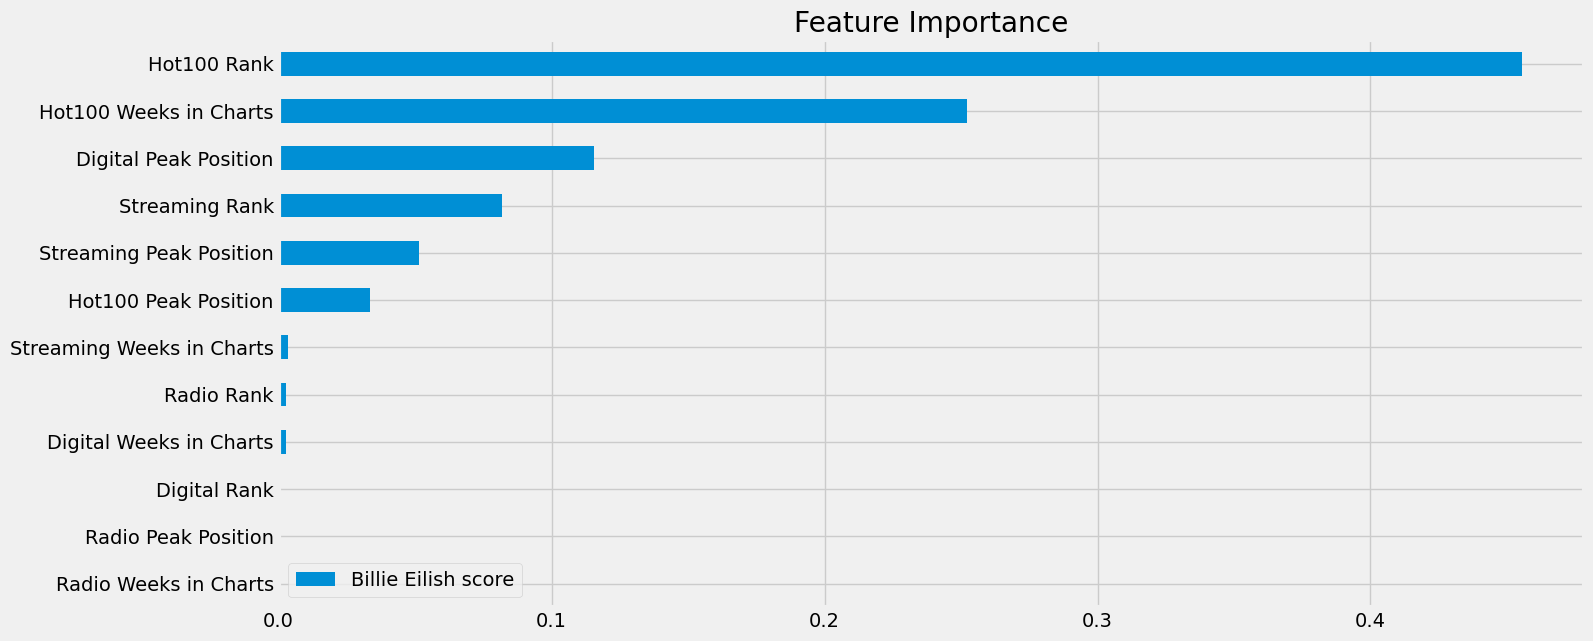

In [95]:
fi4.sort_values(by='Billie Eilish score').plot(kind='barh', title='Feature Importance')
plt.show()

#### Predicting

In [96]:
model.predict(X_test)

array([62.016434, 62.016434, 62.016434, 62.016434, 62.016434, 62.016434,
       62.016434, 62.024296, 62.78024 , 62.78024 , 62.78024 , 62.78024 ,
       62.78024 , 62.78024 , 62.78024 , 62.016434, 62.016434, 62.016434,
       62.016434, 60.49276 , 59.729527, 63.649487, 59.729527, 63.649487,
       63.649487, 59.729527, 61.49806 , 61.49806 , 61.49806 , 61.49806 ,
       63.649487, 62.016434, 62.016434, 62.016434], dtype=float32)

In [97]:
test['Prediction'] = model.predict(X_test)

/var/folders/9f/0437b_tn3hd136wm5vpp7y7h0000gn/T/ipykernel_15918/763973304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = model.predict(X_test)


- Now I have a prediction in the dataframe

In [98]:
df4 = df4.merge(test[['Prediction']], how='left', left_index=True, right_index=True)
df4

Popularity Index Scaled  quarter  month  year  Prediction
Date                                                                 
2020-01-01                81.555304        1      1  2020         NaN
2020-01-08                85.224048        1      1  2020         NaN
2020-01-15                79.064597        1      1  2020         NaN
2020-01-22                77.886559        1      1  2020         NaN
2020-01-29                74.812443        1      1  2020         NaN
...                             ...      ...    ...   ...         ...
2023-12-27                64.811148        4     12  2023   61.498058
2024-01-03                47.157221        1      1  2024   63.649487
2024-01-10                63.323776        1      1  2024   62.016434
2024-01-17                74.004646        1      1  2024   62.016434
2024-01-24                71.917838        1      1  2024   62.016434

[213 rows x 5 columns]

<Axes: xlabel='Date'>

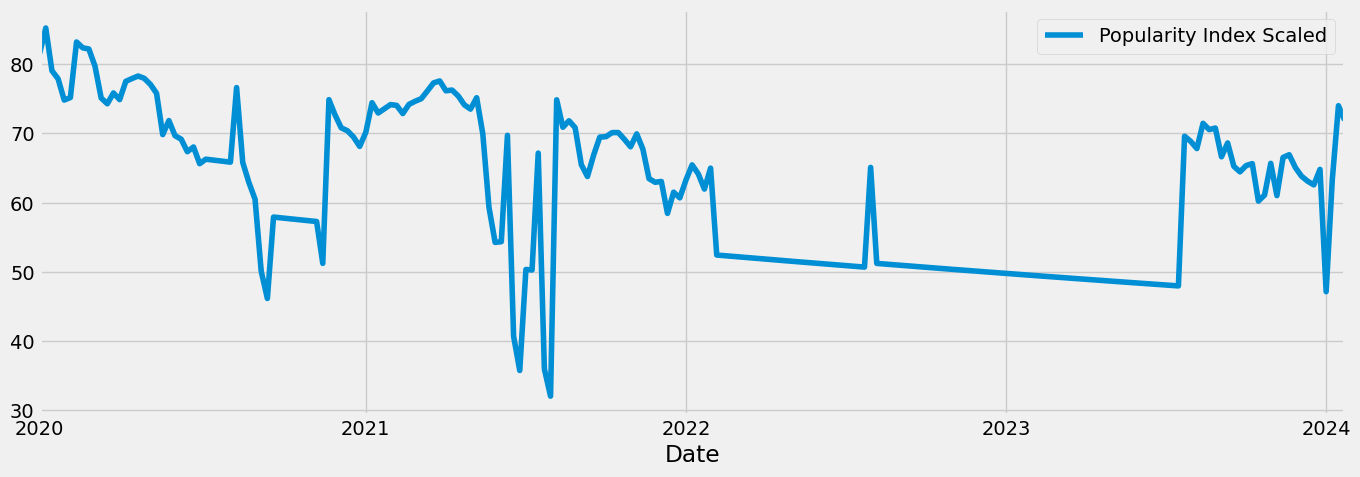

In [99]:
ax = df4[['Popularity Index Scaled']].plot(figsize=(15, 5))
ax

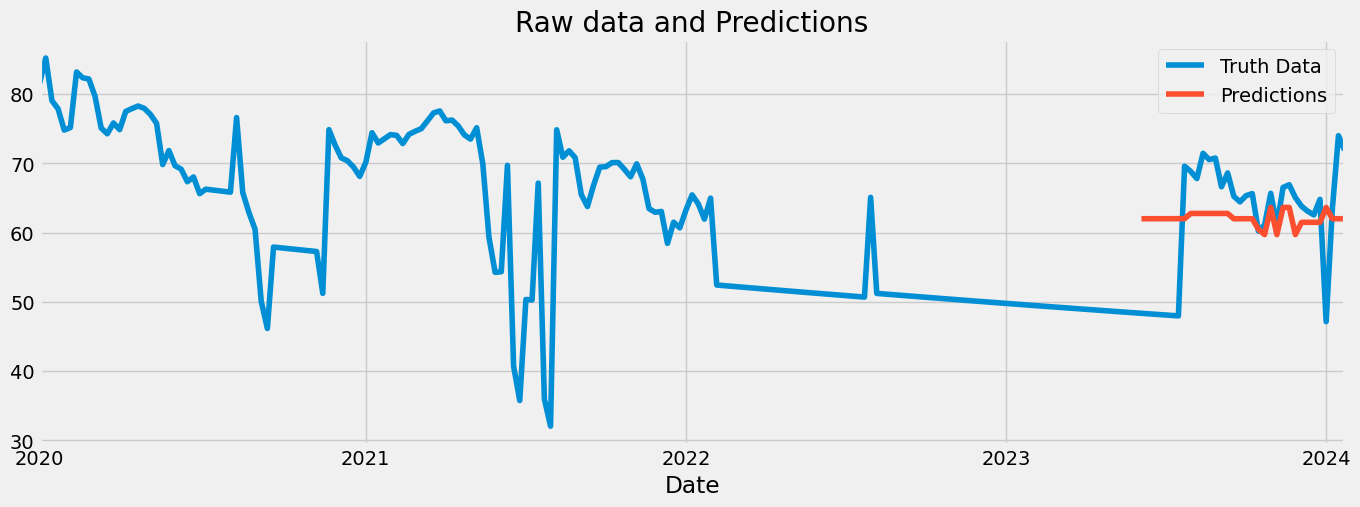

In [100]:
ax = df4[['Popularity Index Scaled']].plot(figsize=(15, 5))
df4['Prediction'].plot(ax=ax, style='-')
ax.set_title('Raw data and Predictions')
plt.legend(['Truth Data','Predictions'])
plt.show()

#### Score

In [101]:
score = root_mean_squared_error(test['Popularity Index Scaled'],test['Prediction'])
print(f'RMSE Score on test set : {score:0.2f}')

RMSE Score on test set : 8.30


## 4. Feature Importance Ranking

In [102]:
fi = pd.concat([fi, fi2, fi3, fi4], axis=1)
fi

Dua Lipa score  Taylor Swift score  Weeknd score  \
Hot100 Rank                      0.001286            0.685646      0.487782   
Digital Rank                     0.001673            0.001319      0.000048   
Radio Rank                       0.002309            0.002411      0.011141   
Streaming Rank                   0.000497            0.001174      0.000589   
Hot100 Peak Position             0.140167            0.080970      0.047327   
Digital Peak Position            0.345857            0.215802      0.004118   
Radio Peak Position              0.001728            0.000355      0.000323   
Streaming Peak Position          0.381834            0.000851      0.000507   
Hot100 Weeks in Charts           0.007485            0.007323      0.098937   
Digital Weeks in Charts          0.005561            0.002697      0.006870   
Radio Weeks in Charts            0.107326            0.001403      0.115192   
Streaming Weeks in Charts        0.004276            0.000050      0.227167   

                           Billie Eilish score  
Hot100 Rank                           0.455382  
Digital Rank                          0.000788  
Radio Rank                            0.002762  
Streaming Rank                        0.081871  
Hot100 Peak Position                  0.033501  
Digital Peak Position                 0.115487  
Radio Peak Position                   0.000568  
Streaming Peak Position               0.051531  
Hot100 Weeks in Charts                0.252080  
Digital Weeks in Charts               0.002497  
Radio Weeks in Charts                 0.000000  
Streaming Weeks in Charts             0.003533

In [103]:
for i, row in fi.iterrows():
    fi.loc[i, 'Importance Score Mean'] = row.mean()

In [104]:
fi

Dua Lipa score  Taylor Swift score  Weeknd score  \
Hot100 Rank                      0.001286            0.685646      0.487782   
Digital Rank                     0.001673            0.001319      0.000048   
Radio Rank                       0.002309            0.002411      0.011141   
Streaming Rank                   0.000497            0.001174      0.000589   
Hot100 Peak Position             0.140167            0.080970      0.047327   
Digital Peak Position            0.345857            0.215802      0.004118   
Radio Peak Position              0.001728            0.000355      0.000323   
Streaming Peak Position          0.381834            0.000851      0.000507   
Hot100 Weeks in Charts           0.007485            0.007323      0.098937   
Digital Weeks in Charts          0.005561            0.002697      0.006870   
Radio Weeks in Charts            0.107326            0.001403      0.115192   
Streaming Weeks in Charts        0.004276            0.000050      0.227167   

                           Billie Eilish score  Importance Score Mean  
Hot100 Rank                           0.455382               0.407524  
Digital Rank                          0.000788               0.000957  
Radio Rank                            0.002762               0.004656  
Streaming Rank                        0.081871               0.021033  
Hot100 Peak Position                  0.033501               0.075491  
Digital Peak Position                 0.115487               0.170316  
Radio Peak Position                   0.000568               0.000744  
Streaming Peak Position               0.051531               0.108681  
Hot100 Weeks in Charts                0.252080               0.091456  
Digital Weeks in Charts               0.002497               0.004406  
Radio Weeks in Charts                 0.000000               0.055980  
Streaming Weeks in Charts             0.003533               0.058757

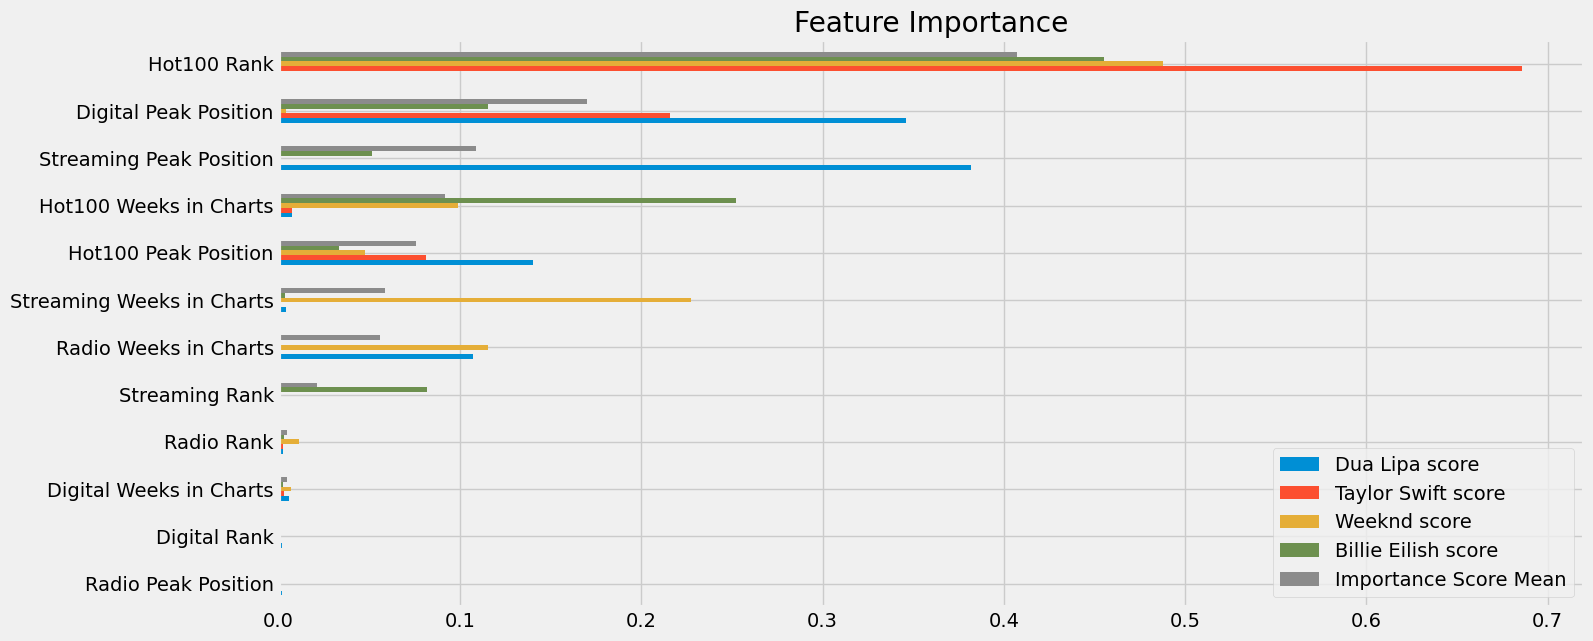

In [105]:
fi.sort_values(by='Importance Score Mean').plot(kind='barh', title='Feature Importance')
plt.show()

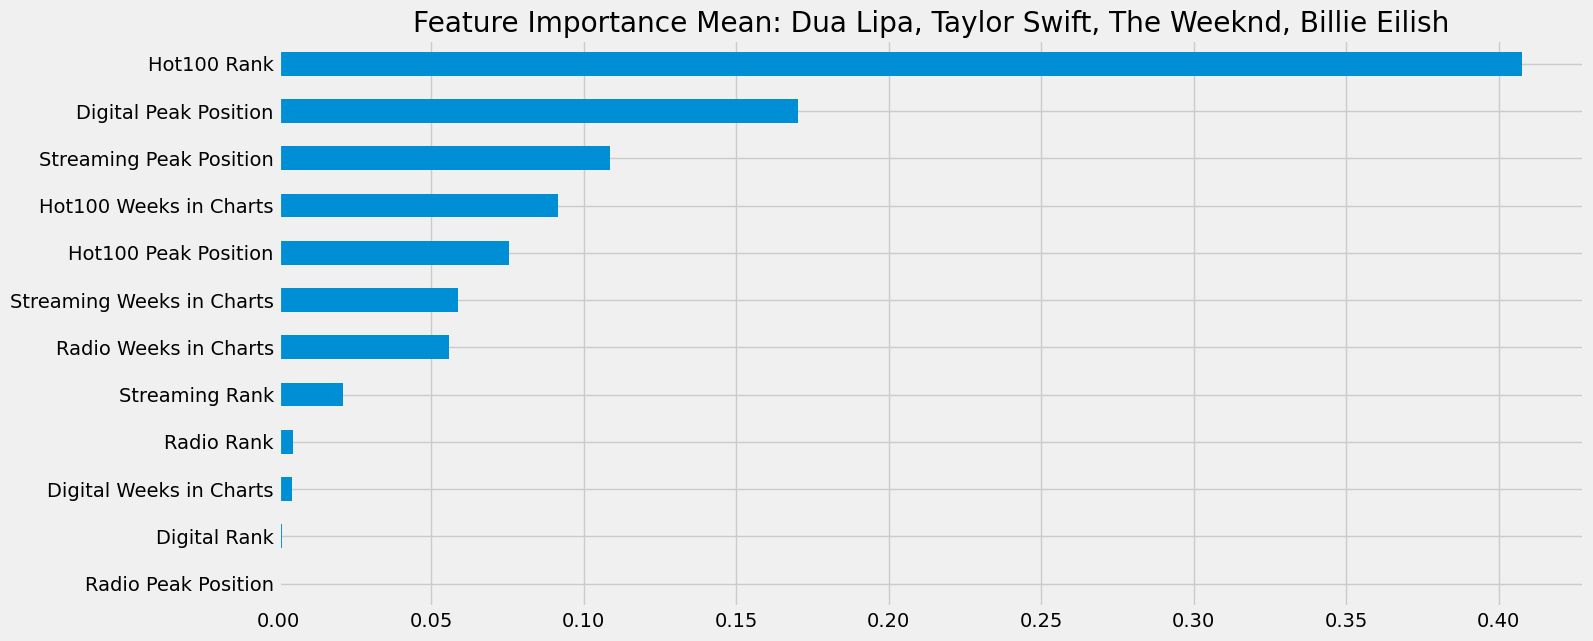

In [106]:
fi_sorted = fi.sort_values(by='Importance Score Mean')
fi_sorted['Importance Score Mean'].plot(kind='barh', title='Feature Importance Mean: Dua Lipa, Taylor Swift, The Weeknd, Billie Eilish')
plt.show()


In [107]:
fi_sorted

Dua Lipa score  Taylor Swift score  Weeknd score  \
Radio Peak Position              0.001728            0.000355      0.000323   
Digital Rank                     0.001673            0.001319      0.000048   
Digital Weeks in Charts          0.005561            0.002697      0.006870   
Radio Rank                       0.002309            0.002411      0.011141   
Streaming Rank                   0.000497            0.001174      0.000589   
Radio Weeks in Charts            0.107326            0.001403      0.115192   
Streaming Weeks in Charts        0.004276            0.000050      0.227167   
Hot100 Peak Position             0.140167            0.080970      0.047327   
Hot100 Weeks in Charts           0.007485            0.007323      0.098937   
Streaming Peak Position          0.381834            0.000851      0.000507   
Digital Peak Position            0.345857            0.215802      0.004118   
Hot100 Rank                      0.001286            0.685646      0.487782   

                           Billie Eilish score  Importance Score Mean  
Radio Peak Position                   0.000568               0.000744  
Digital Rank                          0.000788               0.000957  
Digital Weeks in Charts               0.002497               0.004406  
Radio Rank                            0.002762               0.004656  
Streaming Rank                        0.081871               0.021033  
Radio Weeks in Charts                 0.000000               0.055980  
Streaming Weeks in Charts             0.003533               0.058757  
Hot100 Peak Position                  0.033501               0.075491  
Hot100 Weeks in Charts                0.252080               0.091456  
Streaming Peak Position               0.051531               0.108681  
Digital Peak Position                 0.115487               0.170316  
Hot100 Rank                           0.455382               0.407524

## 5. Modelling the big dataframe

In [108]:
pan_df.shape

(17926, 15)

In [109]:
pan_df = pan_df.set_index('Date').copy()

In [110]:
train = pan_df.loc[pan_df.index < '2023-06-01']
test = pan_df.loc[pan_df.index >= '2023-06-01']

In [111]:
FEATURES = ['Hot100 Rank', 'Digital Rank', 'Radio Rank', 'Streaming Rank',
       'Hot100 Peak Position', 'Digital Peak Position', 'Radio Peak Position',
       'Streaming Peak Position', 'Hot100 Weeks in Charts',
       'Digital Weeks in Charts', 'Radio Weeks in Charts',
       'Streaming Weeks in Charts']
TARGET = ['Popularity Index Scaled']

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

model = xgb.XGBRegressor(
    n_estimators=1000, 
    early_stopping_rounds=50, 
    learning_rate=0.01
    )

model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=True)

[0]	validation_0-rmse:19.06067	validation_1-rmse:18.40766
[1]	validation_0-rmse:18.87587	validation_1-rmse:18.23010
[2]	validation_0-rmse:18.69296	validation_1-rmse:18.05448
[3]	validation_0-rmse:18.51190	validation_1-rmse:17.88075
[4]	validation_0-rmse:18.33272	validation_1-rmse:17.70793
[5]	validation_0-rmse:18.15534	validation_1-rmse:17.53537
[6]	validation_0-rmse:17.97977	validation_1-rmse:17.36483
[7]	validation_0-rmse:17.80602	validation_1-rmse:17.19609
[8]	validation_0-rmse:17.63401	validation_1-rmse:17.02895
[9]	validation_0-rmse:17.46353	validation_1-rmse:16.86428
[10]	validation_0-rmse:17.29501	validation_1-rmse:16.70063
[11]	validation_0-rmse:17.12813	validation_1-rmse:16.54027
[12]	validation_0-rmse:16.96281	validation_1-rmse:16.38082
[13]	validation_0-rmse:16.79942	validation_1-rmse:16.22312
[14]	validation_0-rmse:16.63737	validation_1-rmse:16.06754
[15]	validation_0-rmse:16.47700	validation_1-rmse:15.91286
[16]	validation_0-rmse:16.31833	validation_1-rmse:15.75929
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [112]:
model.feature_importances_

array([0.6201477 , 0.00853125, 0.01478554, 0.01114756, 0.27854368,
       0.00115291, 0.00405954, 0.00613792, 0.01024659, 0.0091002 ,
       0.00877008, 0.02737705], dtype=float32)

In [113]:
fi_pan = pd.DataFrame(
        data = model.feature_importances_,
        index = model.feature_names_in_,
        columns=['Feature Importance']
        )
fi_pan

Feature Importance
Hot100 Rank                          0.620148
Digital Rank                         0.008531
Radio Rank                           0.014786
Streaming Rank                       0.011148
Hot100 Peak Position                 0.278544
Digital Peak Position                0.001153
Radio Peak Position                  0.004060
Streaming Peak Position              0.006138
Hot100 Weeks in Charts               0.010247
Digital Weeks in Charts              0.009100
Radio Weeks in Charts                0.008770
Streaming Weeks in Charts            0.027377

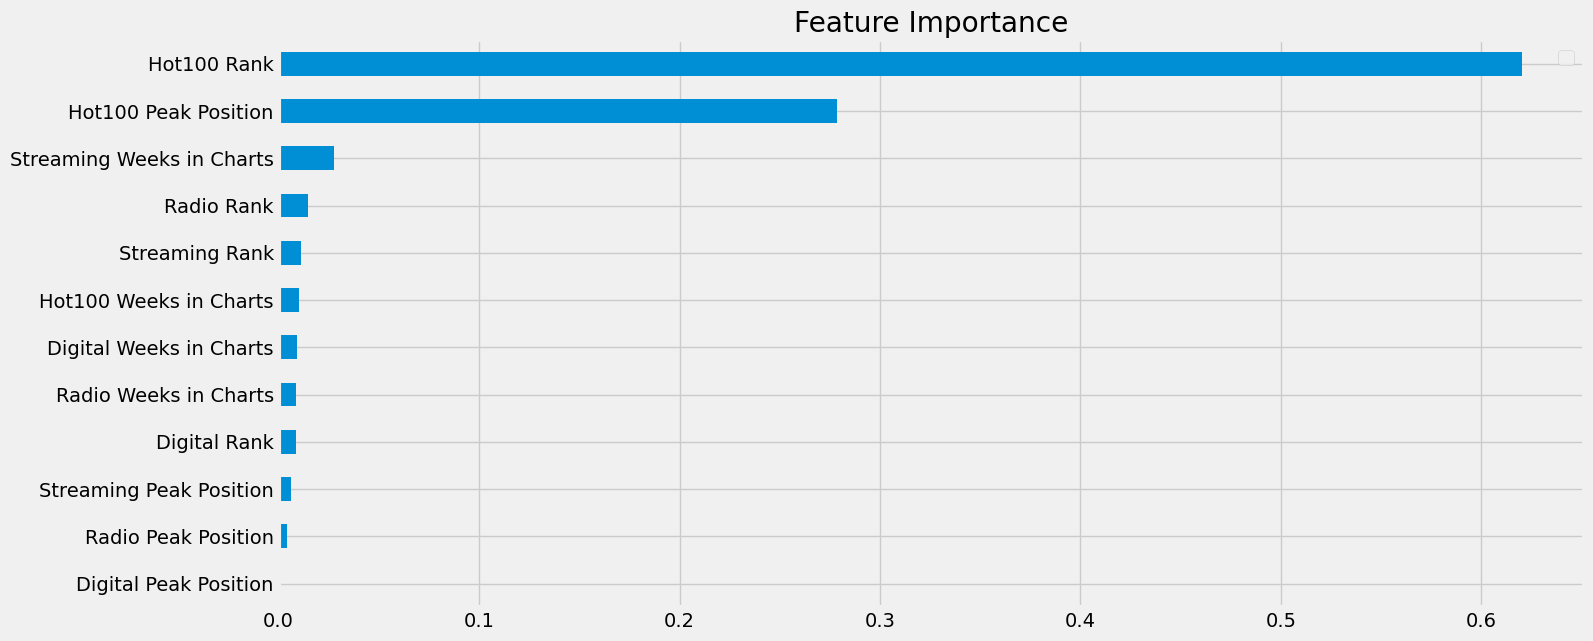

In [114]:
fi_pan.sort_values(by='Feature Importance').plot(kind='barh', title='Feature Importance')
plt.legend(labels=[])
plt.show()

In [115]:
model.predict(X_test)

array([82.83826 , 77.902336, 82.67612 , ..., 38.085934,  5.530842,
       33.77982 ], dtype=float32)

In [116]:
test['Prediction'] = model.predict(X_test)

/var/folders/9f/0437b_tn3hd136wm5vpp7y7h0000gn/T/ipykernel_15918/763973304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = model.predict(X_test)


In [117]:
# Concatenate the DataFrames
pan_df_concatenated = pd.concat([train, test], axis=0)
pan_df_concatenated


Artist  Hot100 Rank  Digital Rank  \
Date                                                                          
2020-01-01                          Mariah Carey            1             5   
2020-01-01                            Brenda Lee            2            30   
2020-01-01                           Bobby Helms            3             0   
2020-01-01                             Burl Ives            4             0   
2020-01-01                           Post Malone            5             6   
...                                          ...          ...           ...   
2024-01-24                Noah Kahan With Hozier           95             0   
2024-01-24  Thomas Rhett Featuring Morgan Wallen           96             0   
2024-01-24                          Travis Scott           97             0   
2024-01-24                         Dylan Gossett           99             0   
2024-01-24                              Rod Wave          100             0   

            Radio Rank  Streaming Rank  Hot100 Peak Position  \
Date                                                           
2020-01-01          26               1                     1   
2020-01-01          40               2                     2   
2020-01-01          41               3                     3   
2020-01-01          44               4                     4   
2020-01-01           1              38                     1   
...                ...             ...                   ...   
2024-01-24           0               0                    37   
2024-01-24           0               0                    55   
2024-01-24           0               0                    19   
2024-01-24           0               0                    89   
2024-01-24           0               0                    30   

            Digital Peak Position  Radio Peak Position  \
Date                                                     
2020-01-01                      1                   12   
2020-01-01                     22                   28   
2020-01-01                      0                   30   
2020-01-01                      0                   32   
2020-01-01                      1                    1   
...                           ...                  ...   
2024-01-24                      0                    0   
2024-01-24                      0                    0   
2024-01-24                      0                    0   
2024-01-24                      0                    0   
2024-01-24                      0                    0   

            Streaming Peak Position  Hot100 Weeks in Charts  \
Date                                                          
2020-01-01                        1                      37   
2020-01-01                        2                      32   
2020-01-01                        2                      30   
2020-01-01                        4                      15   
2020-01-01                        2                      17   
...                             ...                     ...   
2024-01-24                        0                       7   
2024-01-24                        0                       3   
2024-01-24                        0                       7   
2024-01-24                        0                       2   
2024-01-24                        0                      17   

            Digital Weeks in Charts  Radio Weeks in Charts  \
Date                                                         
2020-01-01                       80                     36   
2020-01-01                       26                     19   
2020-01-01                        0                     15   
2020-01-01                        0                     13   
2020-01-01                       17                     16   
...                             ...                    ...   
2024-01-24                        0                      0   
2024-01-24                        0             

<Axes: xlabel='Date'>

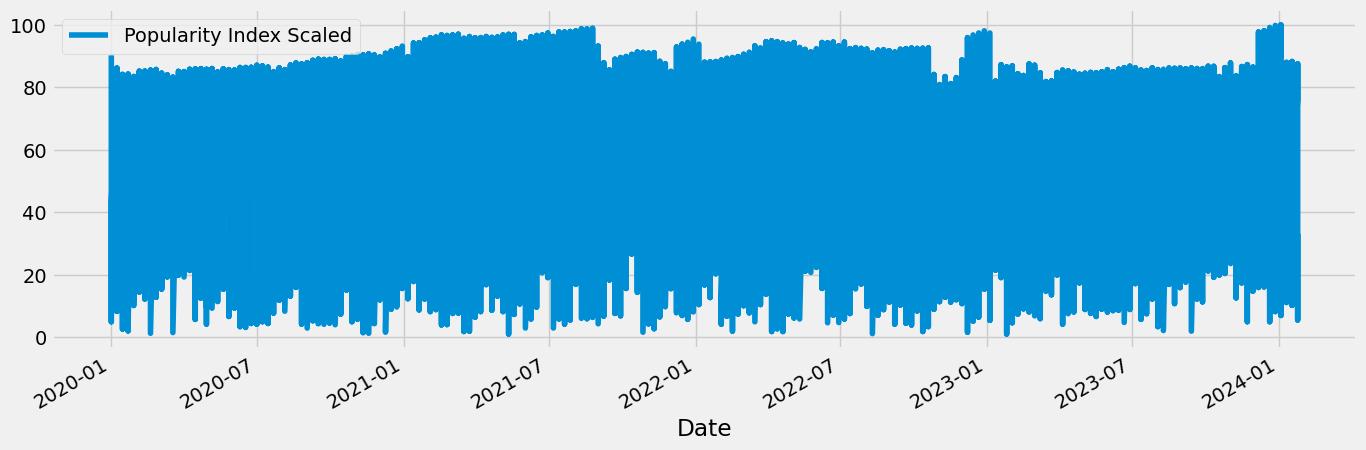

In [118]:
ax = pan_df_concatenated[['Popularity Index Scaled']].plot(figsize=(15, 5))
ax

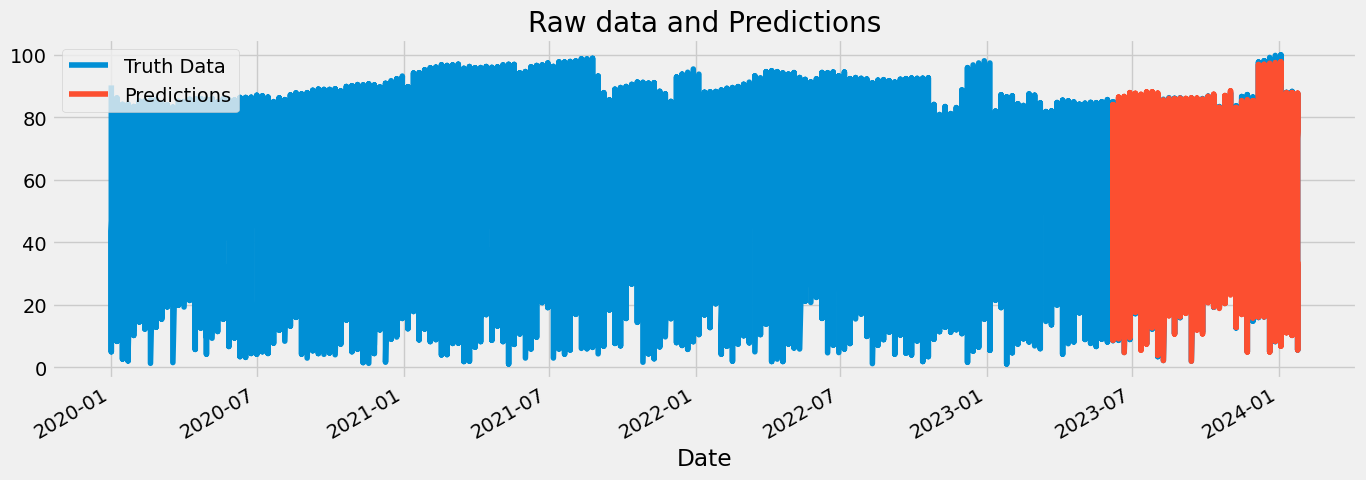

In [119]:
ax = pan_df_concatenated[['Popularity Index Scaled']].plot(figsize=(15, 5))
pan_df_concatenated['Prediction'].plot(ax=ax, style='-')
ax.set_title('Raw data and Predictions')
plt.legend(['Truth Data','Predictions'])
plt.show()

In [120]:
score = root_mean_squared_error(test['Popularity Index Scaled'],test['Prediction'])
print(f'RMSE Score on test set : {score:0.2f}')

RMSE Score on test set : 0.81


In [121]:
pan_df_concatenated.shape

(17926, 15)

---

## 6. Predicting for Billie Eilish

In [122]:
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Modelling and predicting for the whole dataset

In [123]:
billie_df_stripped = billie_df.drop(columns=['Artist','Popularity Index Scaled'])

In [124]:
model.predict(billie_df_stripped)

array([81.51938 , 85.9083  , 78.90231 , 77.609314, 74.97552 , 74.48647 ,
       83.1704  , 81.216805, 81.11784 , 79.507095, 75.35542 , 74.186714,
       75.67015 , 74.647385, 77.192764, 76.81021 , 77.37144 , 77.274025,
       76.334366, 75.955475, 70.02592 , 72.38979 , 69.91012 , 69.23232 ,
       68.3027  , 67.74751 , 65.73999 , 72.493164, 72.493164, 72.39352 ,
       72.39352 , 72.39352 , 76.68687 , 65.98223 , 62.976795, 61.090446,
       50.413666, 46.21416 , 65.98738 , 65.98738 , 65.98738 , 65.98738 ,
       65.98738 , 65.98738 , 65.98738 , 65.98738 , 51.720074, 74.6688  ,
       72.81036 , 71.040886, 69.99577 , 69.19092 , 67.73917 , 71.73087 ,
       74.4984  , 73.35036 , 74.14068 , 74.82403 , 74.36896 , 73.68536 ,
       74.62288 , 74.83835 , 75.16149 , 76.68778 , 77.64895 , 77.786865,
       75.62953 , 75.80013 , 74.73462 , 73.6891  , 72.99926 , 75.15632 ,
       69.60196 , 59.633373, 54.00644 , 54.117012, 69.93678 , 40.9711  ,
       36.05102 , 66.36429 , 66.36429 , 67.63136 , 

In [125]:
billie_df2 = billie_df.copy()

billie_df2['Prediction'] = model.predict(billie_df_stripped)
billie_df2

Artist  Hot100 Rank  Digital Rank  Radio Rank  \
Date                                                               
2020-01-01  Billie Eilish    23.000000     11.000000    32.00000   
2020-01-08  Billie Eilish    14.000000     12.000000    36.00000   
2020-01-15  Billie Eilish    33.000000     20.000000    44.00000   
2020-01-22  Billie Eilish    40.000000     21.000000    43.00000   
2020-01-29  Billie Eilish    41.000000     22.000000    40.00000   
...                   ...          ...           ...         ...   
2023-12-27  Billie Eilish    49.000000     11.000000    11.00000   
2024-01-03  Billie Eilish    30.926271      1.009463     9.91109   
2024-01-10  Billie Eilish    20.000000     14.000000    16.00000   
2024-01-17  Billie Eilish    16.000000      4.000000    15.00000   
2024-01-24  Billie Eilish    20.000000     13.000000    16.00000   

            Streaming Rank  Hot100 Peak Position  Digital Peak Position  \
Date                                                                      
2020-01-01            33.0              1.000000               2.000000   
2020-01-08             9.0              1.000000               2.000000   
2020-01-15            40.0              1.000000               2.000000   
2020-01-22            46.0              1.000000               2.000000   
2020-01-29             0.0              1.000000               2.000000   
...                    ...                   ...                    ...   
2023-12-27             0.0             14.000000              14.000000   
2024-01-03             0.0             10.278167               1.284771   
2024-01-10            43.0             24.000000               8.000000   
2024-01-17            30.0             14.000000               4.000000   
2024-01-24            45.0             14.000000               4.000000   

            Radio Peak Position  Streaming Peak Position  \
Date                                                       
2020-01-01              3.00000                      2.0   
2020-01-08              3.00000                      2.0   
2020-01-15              3.00000                      2.0   
2020-01-22              3.00000                      2.0   
2020-01-29              3.00000                      0.0   
...                         ...                      ...   
2023-12-27             11.00000                      0.0   
2024-01-03              9.91109                      0.0   
2024-01-10             16.00000                     13.0   
2024-01-17             11.00000                      7.0   
2024-01-24             11.00000                      7.0   

            Hot100 Weeks in Charts  Digital Weeks in Charts  \
Date                                                          
2020-01-01               39.000000                     39.0   
2020-01-08               40.000000                     40.0   
2020-01-15               41.000000                     41.0   
2020-01-22               42.000000                     42.0   
2020-01-29               43.000000                     43.0   
...                            ...                      ...   
2023-12-27               23.000000                      0.0   
2024-01-03               14.316019                      0.0   
2024-01-10                0.000000                     16.0   
2024-01-17               25.000000                     17.0   
2024-01-24               26.000000                     18.0   

            Radio Weeks in Charts  Streaming Weeks in Charts  \
Date                                                           
2020-01-01               33.00000                       39.0   
2020-01-08               34.00000                       40.0   
2020-01-15               35.00000                       41.0   
2020-01-22               36.00000                       42.0   
2020-01-29               37.00000                        0.0   
...                           ...                        ...   
2023-12-27               15.00000            

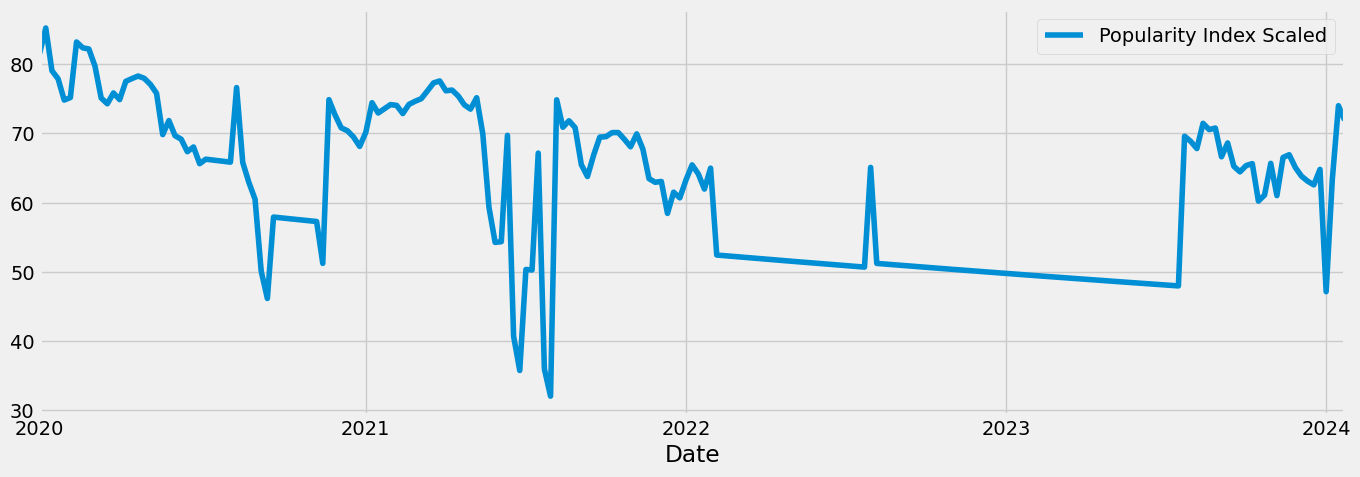

In [126]:
ax = billie_df2[['Popularity Index Scaled']].plot(figsize=(15, 5))

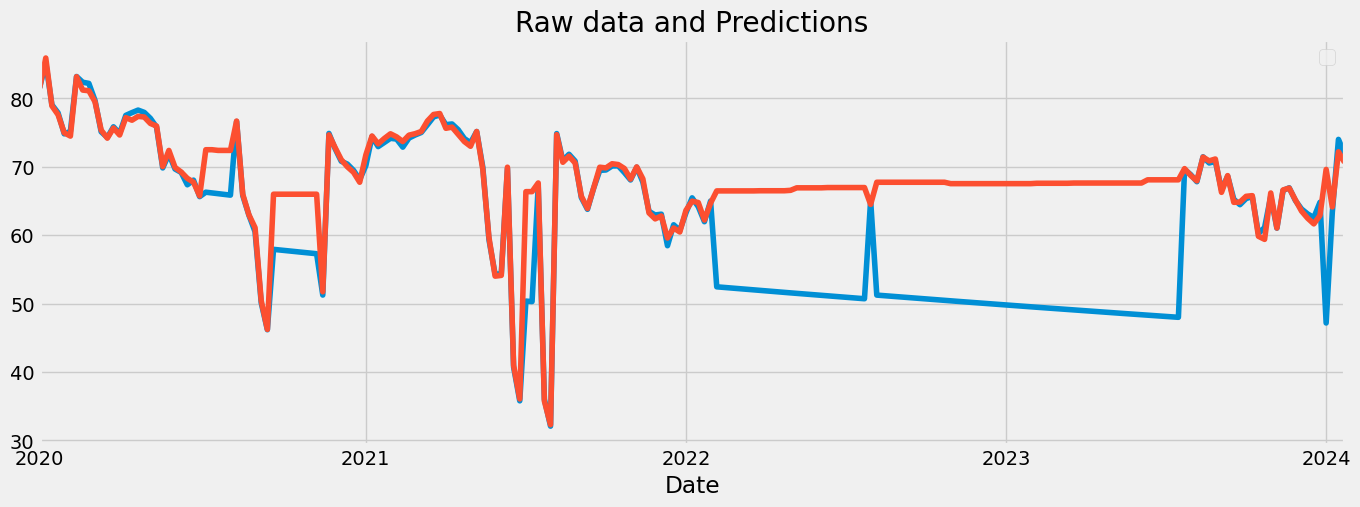

In [127]:
ax = billie_df2[['Popularity Index Scaled']].plot(figsize=(15, 5))
billie_df2['Prediction'].plot(ax=ax, style='-')
ax.set_title('Raw data and Predictions')
plt.legend(labels=[])
#plt.legend(['Truth Data','Predictions'])
plt.show()

### Modelling and predicting for just a sample datetime

In [128]:
billie_df_stripped_sample = billie_df_stripped.loc[billie_df_stripped.index >= '2023-06-01']

In [129]:
model.predict(billie_df_stripped_sample)

array([67.62434 , 68.09272 , 68.09272 , 68.09272 , 68.09272 , 68.09272 ,
       68.09272 , 69.73018 , 68.723465, 67.939316, 71.41538 , 70.859   ,
       71.13816 , 66.26218 , 68.707306, 64.799995, 64.84342 , 65.67832 ,
       65.77805 , 59.835873, 59.38584 , 66.17028 , 61.0416  , 66.611015,
       66.88087 , 65.1573  , 63.52281 , 62.471283, 61.64819 , 62.88805 ,
       69.61417 , 64.1282  , 72.19248 , 70.63081 ], dtype=float32)

In [130]:
billie_df_stripped_sample['Prediction'] = model.predict(billie_df_stripped_sample)

/var/folders/9f/0437b_tn3hd136wm5vpp7y7h0000gn/T/ipykernel_15918/1155220420.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billie_df_stripped_sample['Prediction'] = model.predict(billie_df_stripped_sample)


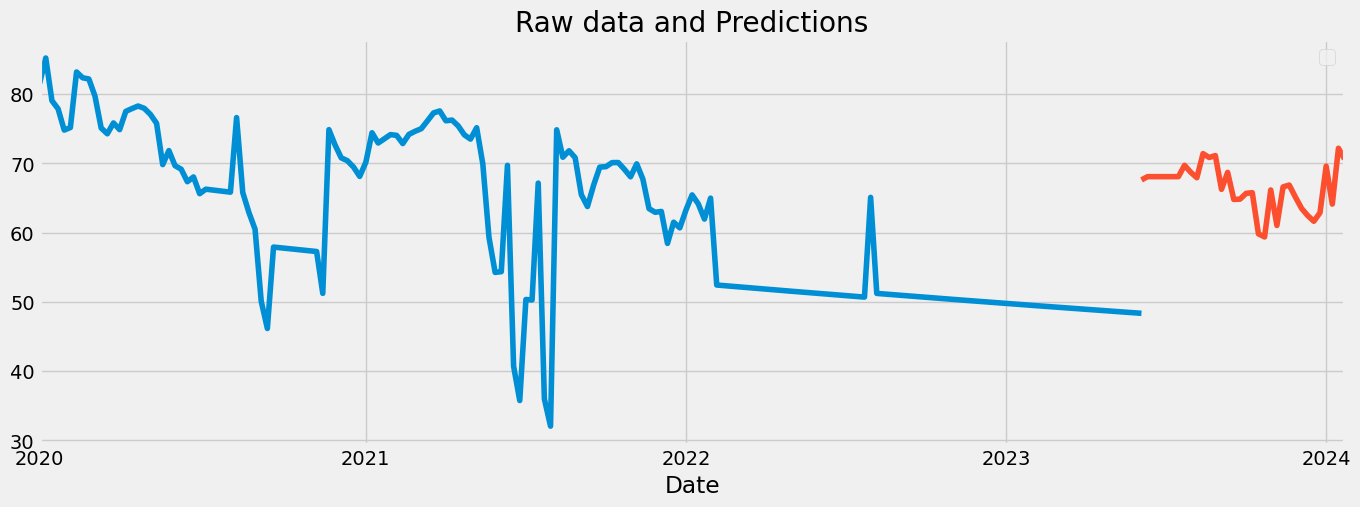

In [131]:
ax = billie_df2[billie_df2.index < '2023-06-08'][['Popularity Index Scaled']].plot(figsize=(15, 5))
billie_df_stripped_sample['Prediction'].plot(ax=ax, style='-')
ax.set_title('Raw data and Predictions')
plt.legend(labels=[])
plt.show()

---

## 7. Predicting for Dua Lipa

In [132]:
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Modelling and predicting for the whole dataset

In [133]:
dua_lipa_df_stripped = dua_lipa_df.drop(columns=['Artist','Popularity Index Scaled'])

In [134]:
model.predict(dua_lipa_df_stripped)

array([56.94718 , 66.61074 , 67.94186 , 68.25437 , 67.96309 , 70.46754 ,
       73.05831 , 76.388794, 77.09675 , 77.33561 , 78.688034, 78.325645,
       79.72018 , 80.07649 , 82.30275 , 82.39954 , 82.67119 , 82.92516 ,
       81.82087 , 81.29304 , 81.74469 , 81.83483 , 81.92852 , 82.96036 ,
       83.16029 , 81.301735, 81.071625, 81.07952 , 79.93505 , 77.193184,
       76.7302  , 78.04464 , 78.37168 , 77.34663 , 77.38368 , 77.32217 ,
       78.67405 , 78.32558 , 77.487755, 76.436005, 76.50327 , 75.11196 ,
       76.36745 , 76.47087 , 75.280525, 64.62271 , 57.46783 , 60.614044,
       60.411335, 66.46194 , 67.31102 , 67.68579 , 68.47503 , 72.5451  ,
       75.67827 , 75.480194, 76.48489 , 77.22532 , 77.4439  , 76.911514,
       77.16464 , 77.13238 , 77.791245, 77.33183 , 79.13829 , 79.63626 ,
       80.01689 , 80.660835, 81.153336, 82.123024, 82.57204 , 83.78573 ,
       85.52416 , 85.33411 , 85.96914 , 86.54945 , 87.012276, 87.27338 ,
       87.9689  , 87.95208 , 88.521866, 89.27983 , 

In [135]:
dua_lipa_df2 = dua_lipa_df.copy()

dua_lipa_df2['Prediction'] = model.predict(dua_lipa_df_stripped)
dua_lipa_df2

Artist  Hot100 Rank  Digital Rank  Radio Rank  Streaming Rank  \
Date                                                                          
2020-01-01  Dua Lipa         52.0          16.0        17.0             0.0   
2020-01-08  Dua Lipa         21.0           8.0        21.0            42.0   
2020-01-15  Dua Lipa         14.0           6.0        16.0            22.0   
2020-01-22  Dua Lipa         14.0           9.0         9.0            25.0   
2020-01-29  Dua Lipa         15.0          12.0         8.0            31.0   
...              ...          ...           ...         ...             ...   
2023-12-27  Dua Lipa         57.0           0.0        15.0             0.0   
2024-01-03  Dua Lipa         59.0           0.0        12.0             0.0   
2024-01-10  Dua Lipa         26.0          20.0        17.0             0.0   
2024-01-17  Dua Lipa         32.0          19.0        22.0            49.0   
2024-01-24  Dua Lipa         39.0          23.0        22.0             0.0   

            Hot100 Peak Position  Digital Peak Position  Radio Peak Position  \
Date                                                                           
2020-01-01                  30.0                    6.0                 17.0   
2020-01-08                  21.0                    6.0                 17.0   
2020-01-15                  14.0                    6.0                 16.0   
2020-01-22                  14.0                    6.0                  9.0   
2020-01-29                  14.0                    6.0                  8.0   
...                          ...                    ...                  ...   
2023-12-27                  11.0                    0.0                 14.0   
2024-01-03                  11.0                    0.0                 12.0   
2024-01-10                  11.0                    5.0                 12.0   
2024-01-17                   6.0                    5.0                  4.0   
2024-01-24                   6.0                    5.0                  4.0   

            Streaming Peak Position  Hot100 Weeks in Charts  \
Date                                                          
2020-01-01                      0.0                     8.0   
2020-01-08                      2.0                     9.0   
2020-01-15                     22.0                    10.0   
2020-01-22                     22.0                    11.0   
2020-01-29                     22.0                    12.0   
...                             ...                     ...   
2023-12-27                      0.0                     6.0   
2024-01-03                      0.0                     7.0   
2024-01-10                      0.0                     8.0   
2024-01-17                      9.0                    28.0   
2024-01-24                      0.0                    29.0   

            Digital Weeks in Charts  Radio Weeks in Charts  \
Date                                                         
2020-01-01                      8.0                    6.0   
2020-01-08                      9.0                    7.0   
2020-01-15                     10.0                    8.0   
2020-01-22                     11.0                    9.0   
2020-01-29                     12.0                   10.0   
...                             ...                    ...   
2023-12-27                      0.0                    6.0   
2024-01-03                      0.0                    7.0   
2024-01-10                      0.0                    8.0   
2024-01-17                     24.0                   28.0   
2024-01-24                     25.0                   29.0   

            Streaming Weeks in Charts  Popularity Index Scaled  Prediction  
Date                                                                        
2020-01-01                        0.0                57.197449   56.947182  
2020-01-08                        0.0                66.622280   66.610741  
2020-01-15

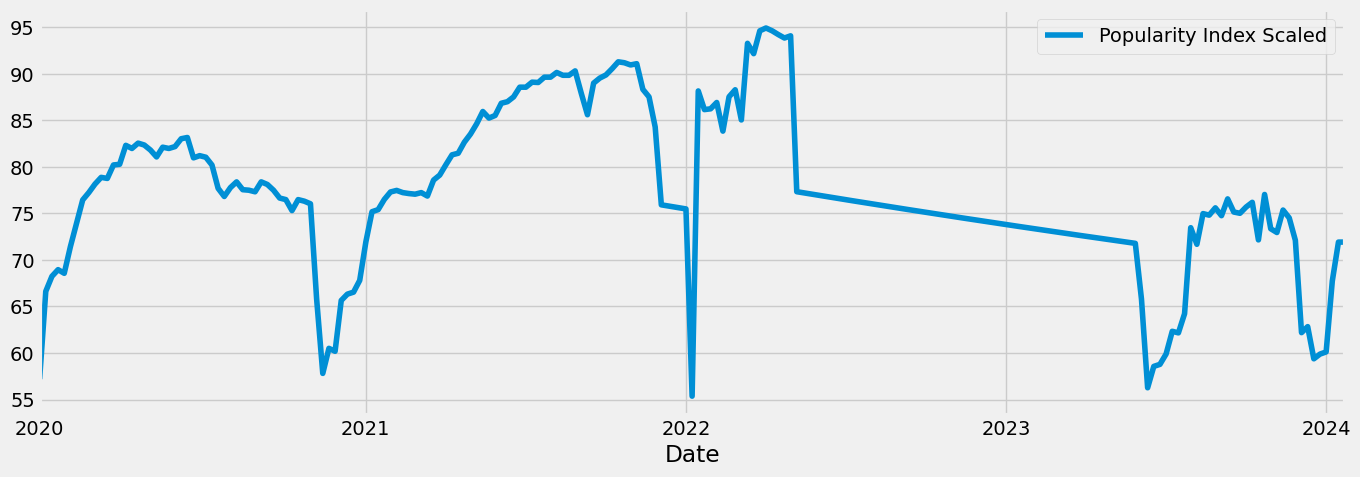

In [136]:
ax = dua_lipa_df2[['Popularity Index Scaled']].plot(figsize=(15, 5))

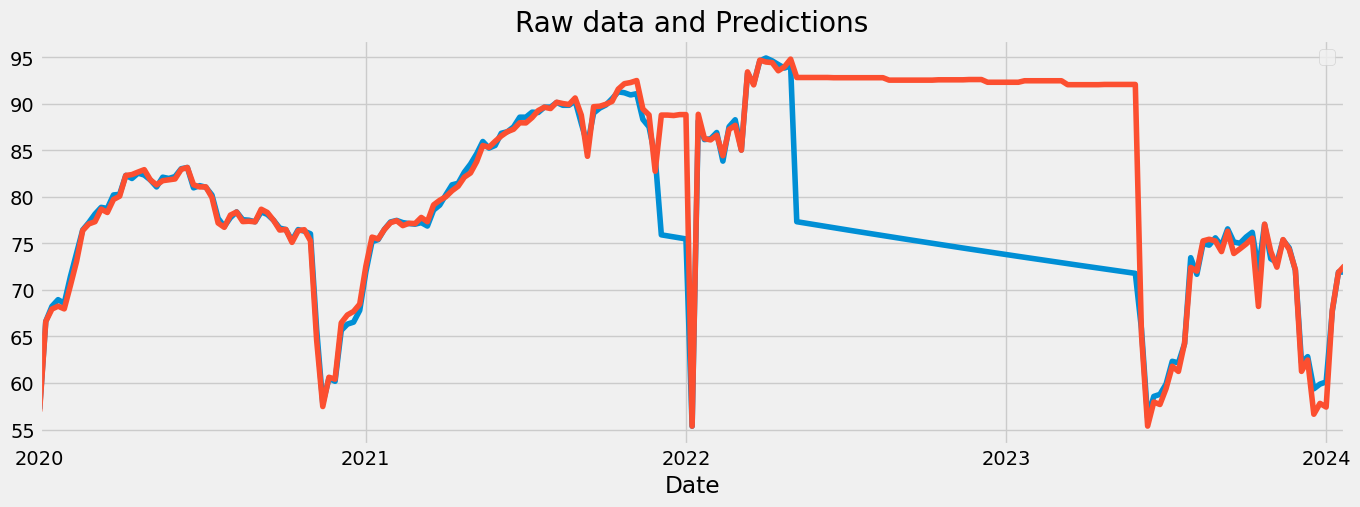

In [137]:
ax = dua_lipa_df2[['Popularity Index Scaled']].plot(figsize=(15, 5))
dua_lipa_df2['Prediction'].plot(ax=ax, style='-')
ax.set_title('Raw data and Predictions')
plt.legend(labels=[])
plt.show()

### Modelling and predicting for just a sample datetime

In [138]:
dua_lipa_df_stripped_sample = dua_lipa_df_stripped.loc[dua_lipa_df_stripped.index >= '2023-06-01']

In [139]:
model.predict(dua_lipa_df_stripped_sample)

array([65.23158 , 55.36498 , 57.95497 , 57.689007, 59.411522, 61.798687,
       61.242786, 64.27682 , 72.41717 , 72.02274 , 75.27007 , 75.44767 ,
       75.257904, 74.119896, 76.30874 , 73.91886 , 74.41765 , 74.940125,
       75.56546 , 68.22675 , 77.07408 , 74.14708 , 72.44932 , 75.410484,
       74.3585  , 72.17721 , 61.248108, 62.468548, 56.642017, 57.806923,
       57.41238 , 67.838684, 71.885414, 72.609924], dtype=float32)

In [140]:
dua_lipa_df_stripped_sample['Prediction'] = model.predict(dua_lipa_df_stripped_sample)

/var/folders/9f/0437b_tn3hd136wm5vpp7y7h0000gn/T/ipykernel_15918/1763806209.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dua_lipa_df_stripped_sample['Prediction'] = model.predict(dua_lipa_df_stripped_sample)


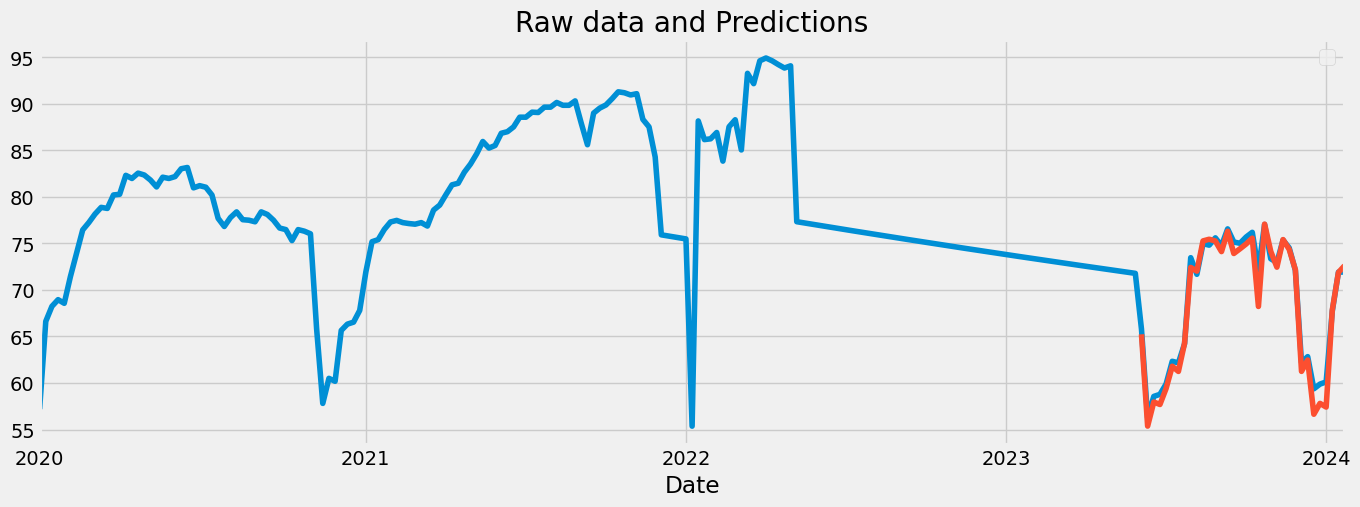

In [141]:
ax = dua_lipa_df2[['Popularity Index Scaled']].plot(figsize=(15, 5))
dua_lipa_df_stripped_sample['Prediction'].plot(ax=ax, style='-')
ax.set_title('Raw data and Predictions')
plt.legend(labels=[])
plt.show()

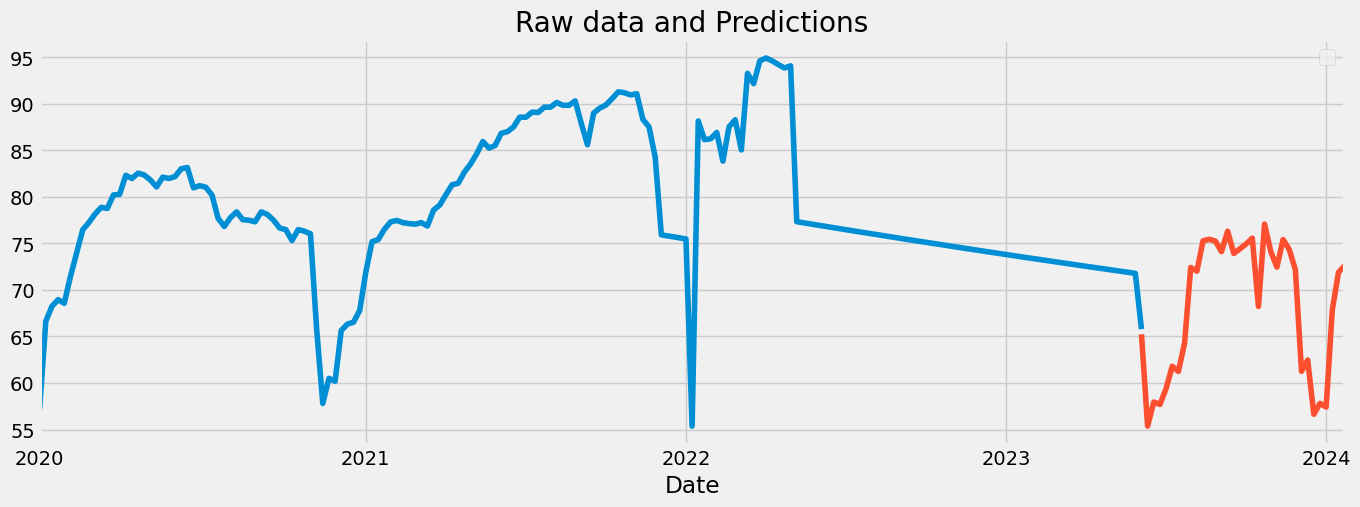

In [142]:
ax = dua_lipa_df2[dua_lipa_df2.index < '2023-06-08'][['Popularity Index Scaled']].plot(figsize=(15, 5))
dua_lipa_df_stripped_sample['Prediction'].plot(ax=ax, style='-')
ax.set_title('Raw data and Predictions')
plt.legend(labels=[])
plt.show()

In [143]:
dua_lipa_df2.loc[dua_lipa_df2.index < '2023-06-01']

Artist  Hot100 Rank  Digital Rank  Radio Rank  Streaming Rank  \
Date                                                                          
2020-01-01  Dua Lipa    52.000000     16.000000   17.000000        0.000000   
2020-01-08  Dua Lipa    21.000000      8.000000   21.000000       42.000000   
2020-01-15  Dua Lipa    14.000000      6.000000   16.000000       22.000000   
2020-01-22  Dua Lipa    14.000000      9.000000    9.000000       25.000000   
2020-01-29  Dua Lipa    15.000000     12.000000    8.000000       31.000000   
...              ...          ...           ...         ...             ...   
2023-05-03  Dua Lipa    13.725594     27.931104   11.901914       20.348433   
2023-05-10  Dua Lipa    13.707611     27.894509   11.886320       20.321773   
2023-05-17  Dua Lipa    13.689674     27.858009   11.870767       20.295182   
2023-05-24  Dua Lipa    13.671785     27.821604   11.855254       20.268660   
2023-05-31  Dua Lipa    13.653942     27.785295   11.839782       20.242208   

            Hot100 Peak Position  Digital Peak Position  Radio Peak Position  \
Date                                                                           
2020-01-01             30.000000               6.000000            17.000000   
2020-01-08             21.000000               6.000000            17.000000   
2020-01-15             14.000000               6.000000            16.000000   
2020-01-22             14.000000               6.000000             9.000000   
2020-01-29             14.000000               6.000000             8.000000   
...                          ...                    ...                  ...   
2023-05-03              1.535731               0.767865             0.767865   
2023-05-10              1.533719               0.766859             0.766859   
2023-05-17              1.531712               0.765856             0.765856   
2023-05-24              1.529710               0.764855             0.764855   
2023-05-31              1.527714               0.763857             0.763857   

            Streaming Peak Position  Hot100 Weeks in Charts  \
Date                                                          
2020-01-01                 0.000000                8.000000   
2020-01-08                 2.000000                9.000000   
2020-01-15                22.000000               10.000000   
2020-01-22                22.000000               11.000000   
2020-01-29                22.000000               12.000000   
...                             ...                     ...   
2023-05-03                 2.303596               56.438108   
2023-05-10                 2.300578               56.364162   
2023-05-17                 2.297568               56.290409   
2023-05-24                 2.294565               56.216850   
2023-05-31                 2.291571               56.143482   

            Digital Weeks in Charts  Radio Weeks in Charts  \
Date                                                         
2020-01-01                 8.000000               6.000000   
2020-01-08                 9.000000               7.000000   
2020-01-15                10.000000               8.000000   
2020-01-22                11.000000               9.000000   
2020-01-29                12.000000              10.000000   
...                             ...                    ...   
2023-05-03                56.438108              55.670242   
2023-05-10                56.364162              55.597303   
2023-05-17                56.290409              55.524554   
2023-05-24                56.216850              55.451995   
2023-05-31                56.143482              55.379625   

            Streaming Weeks in Charts  Popularity Index Scaled  Prediction  
Date                                                                        
2020-01-01                   0.000000                57.197449   56.947182  
2020-01-08                   0.000000                66.622280   66.610741  
2020-01-15

## 9. Predicting for Taylor Swift

In [144]:
taylor_swift_df_stripped = taylor_swift_df.drop(columns=['Artist','Popularity Index Scaled'])

taylor_swift_df2 = taylor_swift_df.copy()

taylor_swift_df2['Prediction'] = model.predict(taylor_swift_df_stripped)
taylor_swift_df2

Artist  Hot100 Rank  Digital Rank  Radio Rank  \
Date                                                              
2020-01-01  Taylor Swift    57.000000     21.000000   21.000000   
2020-01-08  Taylor Swift    34.000000     17.000000   26.000000   
2020-01-15  Taylor Swift    36.000000     16.000000   29.000000   
2020-01-22  Taylor Swift    50.000000     29.000000   38.000000   
2020-01-29  Taylor Swift    43.731377     20.506804   28.165971   
...                  ...          ...           ...         ...   
2023-12-27  Taylor Swift    18.000000      0.000000    1.000000   
2024-01-03  Taylor Swift    19.000000     13.000000    1.000000   
2024-01-10  Taylor Swift     2.000000     15.000000    1.000000   
2024-01-17  Taylor Swift     2.000000     21.000000    1.000000   
2024-01-24  Taylor Swift     3.000000     18.000000    2.000000   

            Streaming Rank  Hot100 Peak Position  Digital Peak Position  \
Date                                                                      
2020-01-01             0.0             10.000000                1.00000   
2020-01-08             0.0             10.000000                1.00000   
2020-01-15             0.0             10.000000                1.00000   
2020-01-22             0.0             10.000000                1.00000   
2020-01-29             0.0              9.882797                0.98828   
...                    ...                   ...                    ...   
2023-12-27            43.0              1.000000                0.00000   
2024-01-03            49.0              1.000000               26.00000   
2024-01-10             3.0              1.000000                1.00000   
2024-01-17             6.0              1.000000                1.00000   
2024-01-24            11.0              1.000000                1.00000   

            Radio Peak Position  Streaming Peak Position  \
Date                                                       
2020-01-01            18.000000                      0.0   
2020-01-08            18.000000                      0.0   
2020-01-15            18.000000                      0.0   
2020-01-22            18.000000                      0.0   
2020-01-29            17.789035                      0.0   
...                         ...                      ...   
2023-12-27             1.000000                      1.0   
2024-01-03             1.000000                      1.0   
2024-01-10             1.000000                      1.0   
2024-01-17             1.000000                      1.0   
2024-01-24             1.000000                      1.0   

            Hot100 Weeks in Charts  Digital Weeks in Charts  \
Date                                                          
2020-01-01               19.000000                19.000000   
2020-01-08               20.000000                20.000000   
2020-01-15               21.000000                21.000000   
2020-01-22               22.000000                22.000000   
2020-01-29               20.259734                20.259734   
...                            ...                      ...   
2023-12-27               33.000000                 0.000000   
2024-01-03               34.000000                 0.000000   
2024-01-10               35.000000                27.000000   
2024-01-17               36.000000                28.000000   
2024-01-24               37.000000                29.000000   

            Radio Weeks in Charts  Streaming Weeks in Charts  \
Date                                                           
2020-01-01              14.000000                        0.0   
2020-01-08              15.000000                        0.0   
2020-01-15              16.000000                        0.0   
2020-01-22              17.000000                        0.0   
2020-01-29              15.318335                        0.0   
...                           ...                        ...   
2023-12-27              27.000000                       3

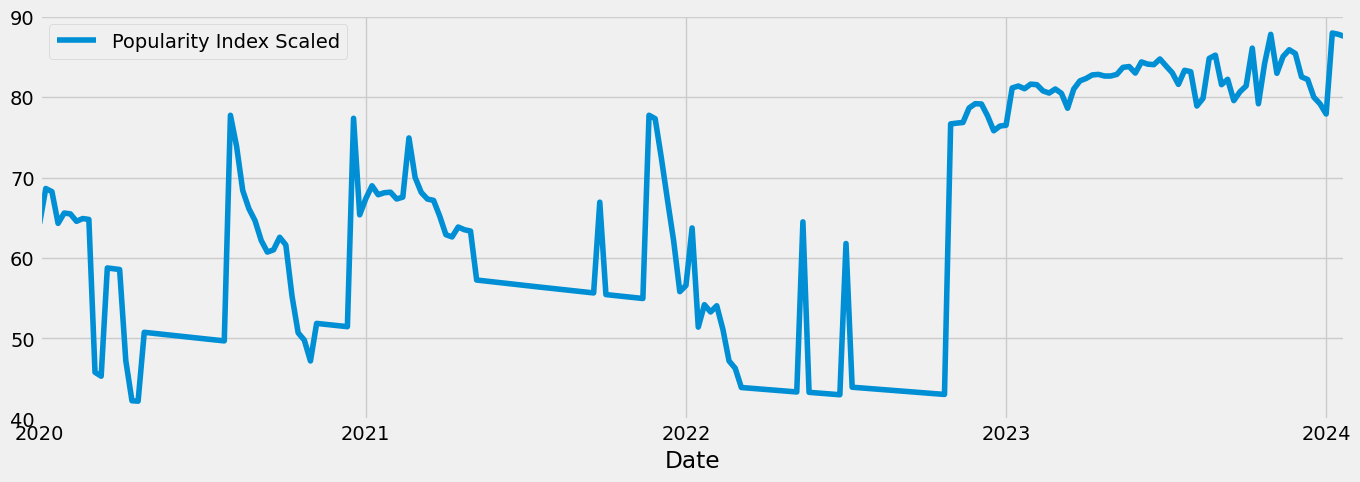

In [145]:
ax = taylor_swift_df2[['Popularity Index Scaled']].plot(figsize=(15, 5))

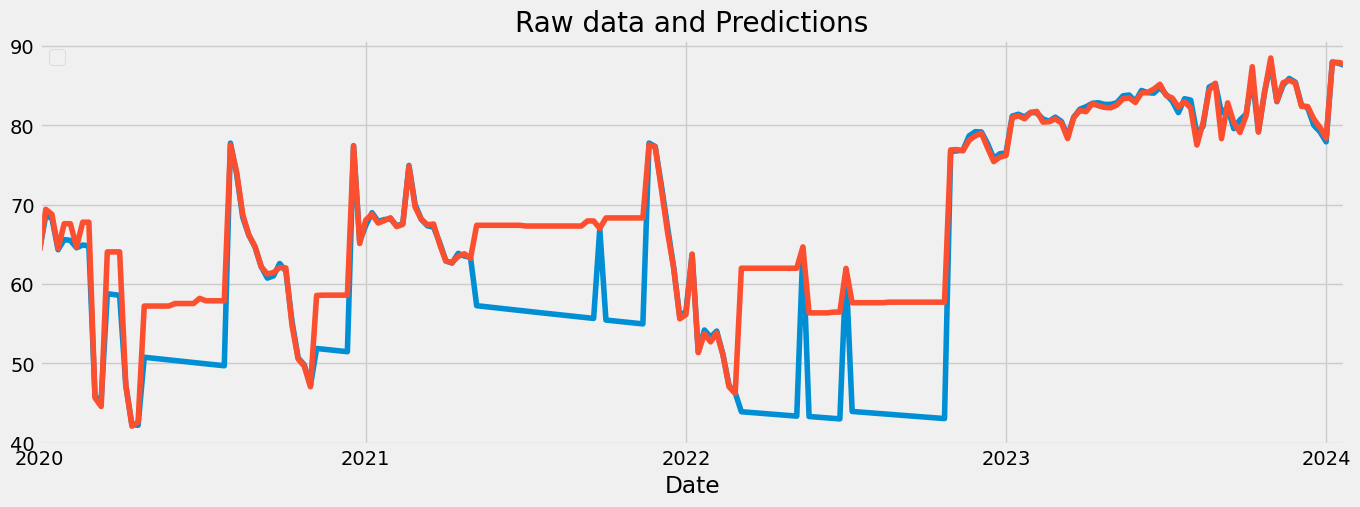

In [146]:
ax = taylor_swift_df2[['Popularity Index Scaled']].plot(figsize=(15, 5))
taylor_swift_df2['Prediction'].plot(ax=ax, style='-')
ax.set_title('Raw data and Predictions')
plt.legend(labels=[])
plt.show()

### Modelling and predicting for just a sample datetime

In [147]:
taylor_swift_df_stripped_sample =taylor_swift_df_stripped.loc[taylor_swift_df_stripped.index >= '2023-06-01']

model.predict(taylor_swift_df_stripped_sample)

array([84.07177 , 84.142624, 84.56161 , 85.17666 , 83.76262 , 83.44561 ,
       82.30611 , 82.9851  , 82.185   , 77.52181 , 80.29885 , 84.44505 ,
       85.30735 , 78.31789 , 82.83292 , 80.34474 , 79.107155, 81.2386  ,
       87.39158 , 79.15111 , 84.197464, 88.48893 , 83.04788 , 85.37282 ,
       85.674355, 85.33287 , 82.390854, 82.37316 , 80.77919 , 79.738304,
       78.38563 , 87.923294, 87.93323 , 87.73834 ], dtype=float32)

In [148]:
taylor_swift_df_stripped_sample['Prediction'] = model.predict(taylor_swift_df_stripped_sample)

/var/folders/9f/0437b_tn3hd136wm5vpp7y7h0000gn/T/ipykernel_15918/3835451222.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taylor_swift_df_stripped_sample['Prediction'] = model.predict(taylor_swift_df_stripped_sample)


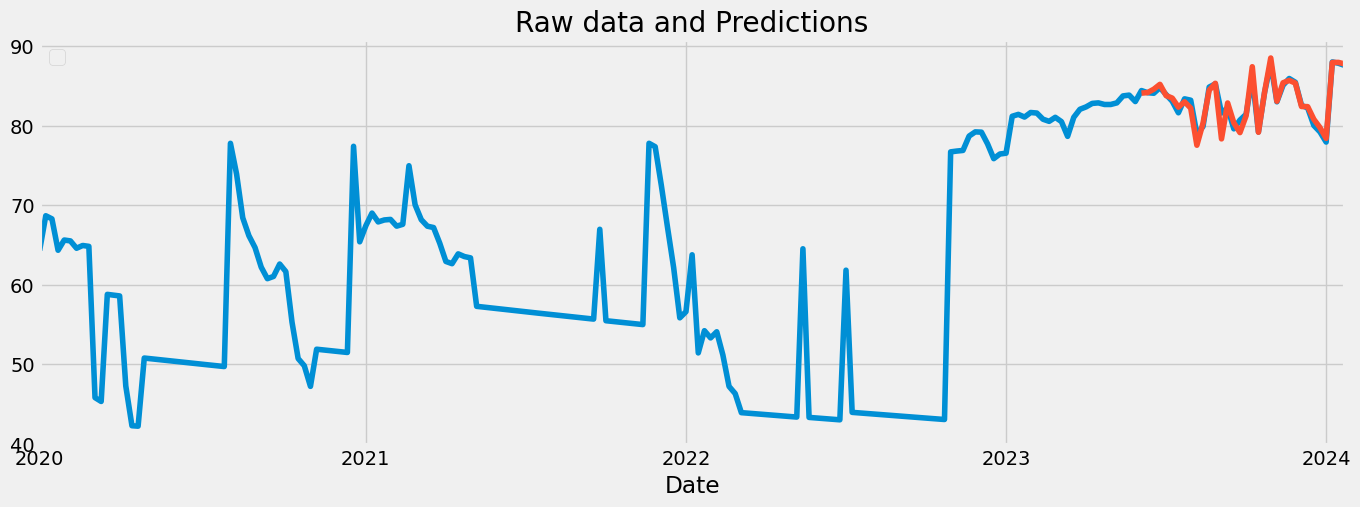

In [149]:
ax = taylor_swift_df2[['Popularity Index Scaled']].plot(figsize=(15, 5))
taylor_swift_df_stripped_sample['Prediction'].plot(ax=ax, style='-')
ax.set_title('Raw data and Predictions')
plt.legend(labels=[])
plt.show()

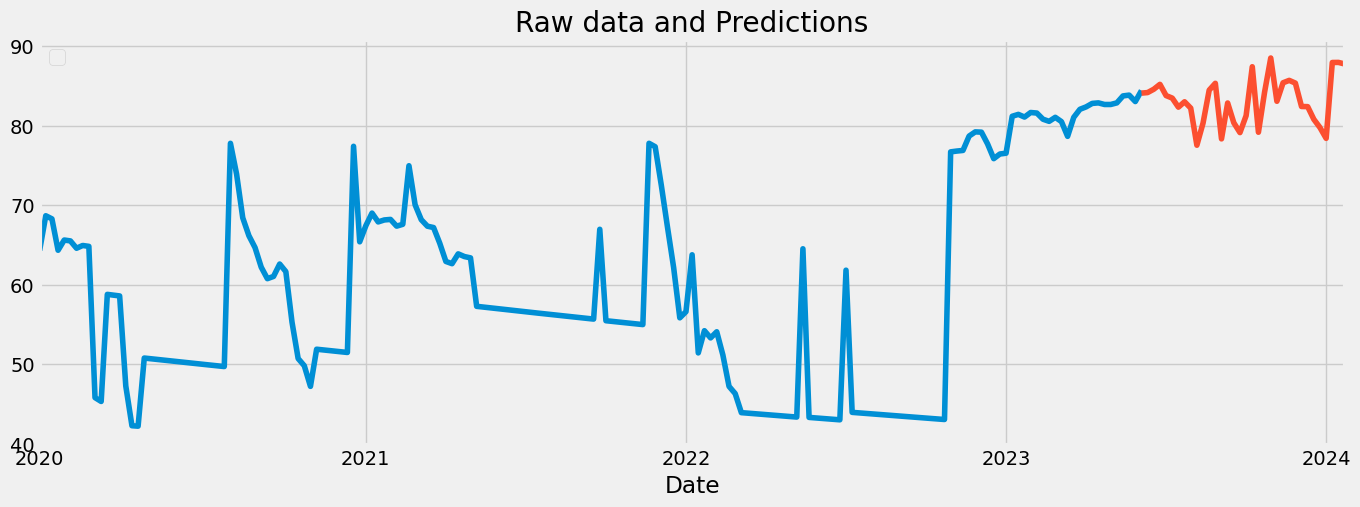

In [150]:
ax = taylor_swift_df2[taylor_swift_df2.index < '2023-06-08'][['Popularity Index Scaled']].plot(figsize=(15, 5))
taylor_swift_df_stripped_sample['Prediction'].plot(ax=ax, style='-')
ax.set_title('Raw data and Predictions')
plt.legend(labels=[])
plt.show()

In [154]:
fi2 = fi.drop(columns=['Weeknd score','Billie Eilish score','Importance Score Mean'])
fi3 = fi2.reset_index()
fi3.rename(columns={'index':'Feature Importance Metrics','Dua Lipa score':'Dua Lipa','Taylor Swift score':'Taylor Swift'}, inplace=True)

In [155]:
#fi3.to_csv('feature_importance.csv', index=False)

In [156]:
fi_pan = fi_pan.reset_index()
fi_pan

index  Feature Importance
0                 Hot100 Rank            0.620148
1                Digital Rank            0.008531
2                  Radio Rank            0.014786
3              Streaming Rank            0.011148
4        Hot100 Peak Position            0.278544
5       Digital Peak Position            0.001153
6         Radio Peak Position            0.004060
7     Streaming Peak Position            0.006138
8      Hot100 Weeks in Charts            0.010247
9     Digital Weeks in Charts            0.009100
10      Radio Weeks in Charts            0.008770
11  Streaming Weeks in Charts            0.027377

In [157]:
#fi_pan.to_csv('all_feature_importance.csv', index=False)